# **Implementación del modelo original**

## **Librerías y modulos necesarios**

In [2]:
import time
import random
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.stats import jarque_bera
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import train_test_split

## **Datos**

In [35]:
file_path = r"C:\Users\kamac\OneDrive\Desktop\MachineLearningUN\EDA\ws_modelos.xlsx"
data = pd.read_excel(file_path)

## **Métodos para realizar las gráficas**

In [40]:
def grafica(nombre_modelo, y_train, y_train_pred, y_test, y_test_pred):

    plt.figure(figsize=(14, 6))
    n_display = 100
    # Gráfico del conjunto de entrenamiento
    plt.subplot(1, 2, 1)
    plt.plot(range(n_display), y_train[:n_display], label='Velocidad original', color='#00008B', linestyle='-', marker='o')
    plt.plot(range(n_display), y_train_pred[:n_display], label='Velocidad predicha', color='#00B2EE', linestyle='--', marker='x')
    plt.xlabel('Índice')
    plt.ylabel('Velocidad del viento')
    plt.title(f"{nombre_modelo} (Entrenamiento)")
    plt.legend()
    plt.grid(True)


    # Gráfico del conjunto de prueba
    plt.subplot(1, 2, 2)
    plt.plot(range(n_display), y_test[:n_display], label='Velocidad original', color='#00008B', linestyle='-', marker='o')
    plt.plot(range(n_display), y_test_pred[:n_display], label='Velocidad predicha', color='#00B2EE', linestyle='--', marker='x')
    plt.xlabel('Índice')
    plt.ylabel('Velocidad del viento')
    plt.title(f"{nombre_modelo} (Prueba)")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

In [4]:
def grafica_residuos(nombre_modelo, residuos):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histograma de los residuos
    axes[0].hist(residuos, bins=30, color='#00008B', edgecolor = 'black')
    axes[0].set_title(f"Histograma de los Residuos ({nombre_modelo})")
    axes[0].set_xlabel("Valor del Residuo")
    axes[0].set_ylabel("Frecuencia")

    # Gráfico de autocorrelación
    sm.graphics.tsa.plot_acf(residuos, lags=20, ax=axes[1], color='#00008B', vlines_kwargs={'color': '#00008B'}, alpha = 0.05)
    axes[1].set_title(f"Autocorrelación de los Residuos ({nombre_modelo})")

    plt.tight_layout()
    plt.grid(True)
    plt.show()

## **BO - XGBoost**

**Descripción**:  
La **Optimización Bayesiana** busca de manera eficiente los mejores hiperparámetros de un modelo utilizando un modelo probabilístico. Optimiza el rendimiento del **XGBoost** iterando sobre el espacio de parámetros y eligiendo los mejores valores basados en el rendimiento anterior.

**Ventajas**:  
- Eficiente en la búsqueda de hiperparámetros.
- No requiere búsqueda exhaustiva.

In [ ]:
def evaluate_bo_xgboost(X_train, y_train, X_test, y_test, results, resultados_graficos):
    # Definir la función de optimización para el modelo XGBoost
    def optimize_xgboost(max_depth, learning_rate, n_estimators):
        # Definir el diccionario de parámetros para el modelo XGBoost
        params = {
            "max_depth": int(max_depth),  # Convertir max_depth a entero
            "learning_rate": learning_rate,  # Tasa de aprendizaje
            "n_estimators": int(n_estimators),  # Número de estimadores
            "objective": "reg:squarederror",  # Objetivo de regresión
            "random_state": 11,  # Fijar la semilla para la aleatoriedad
        }
        
        # Crear y entrenar el modelo XGBoost con los parámetros dados
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)  # Entrenar el modelo
        
        # Hacer predicciones sobre el conjunto de prueba
        predictions = model.predict(X_test)
        
        # Calcular el R² para evaluar el rendimiento del modelo
        r2 = r2_score(y_test, predictions)
        
        return r2  # Devolver el R² como valor de evaluación

    # Definir los límites de los parámetros que serán optimizados
    param_bounds = {
        "max_depth": (5, 20),  # Límite de profundidad del árbol: entre 5 y 20
        "learning_rate": (0.01, 0.3),  # Tasa de aprendizaje: entre 0.01 y 0.3
        "n_estimators": (10, 200),  # Número de estimadores: entre 10 y 200
    }

    # Optimización Bayesiana: busca los mejores parámetros dentro de los límites
    optimizer = BayesianOptimization(
        f=optimize_xgboost,  # Función que optimizamos
        pbounds=param_bounds,  # Límites de los parámetros
        random_state=11  # Semilla para la aleatoriedad
    )

    # Medir el tiempo de ejecución de la optimización
    start_time = time.time()
    optimizer.maximize(init_points=10, n_iter=20)  # Inicializar con 10 puntos y luego 20 iteraciones
    end_time = time.time()
    execution_time = end_time - start_time  # Tiempo total de ejecución

    # Obtener los mejores parámetros encontrados por la optimización
    best_params = optimizer.max['params']
    
    # Asegurarse de que los parámetros max_depth y n_estimators sean enteros
    best_params["max_depth"] = int(best_params["max_depth"])
    best_params["n_estimators"] = int(best_params["n_estimators"])

    # Crear el modelo XGBoost con los mejores parámetros
    model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=11)
    model.fit(X_train, y_train)  # Entrenar el modelo con los mejores parámetros

    # Hacer predicciones sobre los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Calcular los residuos: diferencia entre los valores reales y las predicciones
    residuals = y_test - y_pred


    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    ljung_box_p_value = acorr_ljungbox(residuals, lags=[30], return_df=True)['lb_pvalue'].iloc[0]
    jarque_bera_p_value = jarque_bera(residuals)[1]

    print(f"Best params: {best_params}")

    # Agregar resultados
    results.append({
        'Modelo': 'BO - XGBoost',
        'MAPE': mape,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'Ljung-Box p-value': ljung_box_p_value,
        'Jarque-Bera p-value': jarque_bera_p_value,
        'Tiempo de ejecución (s)': execution_time
    })

    # Almacenar gráficos
    resultados_graficos.append({
        'nombre_modelo': 'BO - XGBoost',
        'y_train': y_train,
        'y_train_pred': y_train_pred,
        'y_test': y_test,
        'y_test_pred': y_pred,
        'residuos': residuals
    })


## **GWO - XGBoost**

**Descripción**:  
El **Algoritmo de Optimización de Lobos (GWO)** simula el comportamiento jerárquico de una manada de lobos, donde el lobo alfa lidera. Se utiliza para optimizar los parámetros de **XGBoost** mediante exploración y explotación del espacio de búsqueda.

**Ventajas**:  
- Equilibrio entre exploración global y explotación local.
- Fácil de implementar.


In [ ]:
def evaluate_gwo_xgboost(X_train, y_train, X_test, y_test, results, resultados_graficos, n_wolves=5, n_iterations=20):
    SEED = 10  # Semilla para asegurar la reproducibilidad
    random.seed(SEED)
    np.random.seed(SEED)

    # Función para evaluar el modelo XGBoost con un conjunto de parámetros
    def evaluate_gwo_metrics(params):
        max_depth, learning_rate, n_estimators = params  # Extraer parámetros del lobo (solución)
        
        # Crear el modelo XGBoost con los parámetros dados
        model = XGBRegressor(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            objective="reg:squarederror",  # Objetivo de regresión
            random_state=SEED  # Fijar semilla para XGBoost
        )
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predicciones en los conjuntos de entrenamiento y prueba
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calcular métricas para el conjunto de entrenamiento y prueba
        r2_train = r2_score(y_train, y_train_pred)  # Coeficiente de determinación R²
        r2_test = r2_score(y_test, y_test_pred)  # Coeficiente de determinación R² en prueba
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))  # RMSE en entrenamiento
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))  # RMSE en prueba

        return r2_test, r2_train, rmse_train, rmse_test, model  # Devolver el rendimiento y el modelo entrenado

    # Definir los límites de búsqueda para los parámetros
    bounds = {
        'max_depth': (3, 20),         # Profundidad del árbol: entre 3 y 20
        'learning_rate': (0.01, 0.3), # Tasa de aprendizaje: entre 0.01 y 0.3
        'n_estimators': (50, 200)     # Número de árboles: entre 50 y 200
    }

    # Inicializar la población de lobos (n_wolves), donde cada lobo tiene una posición aleatoria
    wolves = [np.array([random.uniform(bounds[k][0], bounds[k][1]) for k in bounds.keys()]) for _ in range(n_wolves)]
    
    # Inicializar variables para el "lobo alfa" (la mejor solución encontrada)
    alpha, alpha_score = None, float("-inf")
    best_r2_train, best_r2_test, best_rmse_train, best_rmse_test, best_model = None, None, None, None, None

    # Medir el tiempo de ejecución
    start_time = time.time()

    # Ciclo de iteraciones de optimización
    for iteration in range(n_iterations):
        for wolf in wolves:
            # Evaluar cada lobo (solución) con la función de evaluación
            r2_test_value, r2_train, rmse_train, rmse_test, model = evaluate_gwo_metrics(wolf)

            # Si el R² en el conjunto de prueba es mejor, actualizamos el "lobo alfa"
            if r2_test_value > alpha_score:
                alpha = wolf  # Actualizamos la mejor solución
                alpha_score = r2_test_value  # Mejor puntuación R²
                # Almacenamos las métricas asociadas al "lobo alfa"
                best_r2_train, best_r2_test, best_rmse_train, best_rmse_test, best_model = r2_train, r2_test_value, rmse_train, rmse_test, model

        # Actualizar las posiciones de los lobos en la manada
        for i, wolf in enumerate(wolves):
            for j in range(len(wolf)):
                # Coeficientes de movimiento de los lobos
                A1 = 2 * random.random() - 1
                C1 = 2 * random.random()
                X1 = alpha[j] - A1 * abs(C1 * alpha[j] - wolf[j])

                A2 = 2 * random.random() - 1
                C2 = 2 * random.random()
                X2 = alpha[j] - A2 * abs(C2 * alpha[j] - wolf[j])

                A3 = 2 * random.random() - 1
                C3 = 2 * random.random()
                X3 = alpha[j] - A3 * abs(C3 * alpha[j] - wolf[j])

                # Actualización de la posición del lobo: promedio de las tres posiciones
                wolf[j] = (X1 + X2 + X3) / 3

                # Restringir la posición dentro de los límites definidos para cada parámetro
                wolf[j] = np.clip(wolf[j], bounds[list(bounds.keys())[j]][0], bounds[list(bounds.keys())[j]][1])

        # Mostrar el progreso de la optimización
        print(f"Iteración {iteration + 1}/{n_iterations}: Mejor R² Test = {alpha_score}")

    # Medir el tiempo final de ejecución
    end_time = time.time()
    execution_time = end_time - start_time  # Tiempo total de ejecución
    # Calcular residuos
    residuos = y_test - best_model.predict(X_test)
    ljung_box_p_value = acorr_ljungbox(residuos, lags=[30], return_df=True)['lb_pvalue'].iloc[0]
    jarque_bera_p_value = jarque_bera(residuos)[1]

    # Agregar resultados
    results.append({
        'Modelo': 'GWO - XGBoost',
        'MAPE': np.mean(np.abs((y_test - best_model.predict(X_test)) / y_test)) * 100,
        'MAE': mean_absolute_error(y_test, best_model.predict(X_test)),
        'MSE': best_rmse_test**2,
        'RMSE': best_rmse_test,
        'R²': best_r2_test,
        'Ljung-Box p-value': ljung_box_p_value,
        'Jarque-Bera p-value': jarque_bera_p_value,
        'Tiempo de ejecución (s)': execution_time
    })

    # Almacenar gráficos
    resultados_graficos.append({
        'nombre_modelo': 'GWO - XGBoost',
        'y_train': y_train,
        'y_train_pred': best_model.predict(X_train),
        'y_test': y_test,
        'y_test_pred': best_model.predict(X_test),
        'residuos': residuos
    })


## **WOA - XGBoost**

**Descripción**:  
El **Algoritmo de Optimización de Ballenas (WOA)** simula el comportamiento de las ballenas al buscar soluciones óptimas a través de movimientos espirales (exploración) y lineales (explotación) para optimizar los hiperparámetros de **XGBoost**.

**Ventajas**:  
- Buena combinación de exploración y explotación.
- Eficiente para optimización global.

In [ ]:

def evaluate_woa_xgboost(X_train, y_train, X_test, y_test, results, resultados_graficos, n_whales=10, n_iterations=20):
    SEED = 10  # Semilla para la reproducibilidad
    random.seed(SEED)
    np.random.seed(SEED)

    # Función que evalúa un conjunto de parámetros para XGBoost
    def evaluate_woa_metrics(params):
        max_depth, learning_rate, n_estimators = params  # Desempaquetar los parámetros

        # Crear el modelo XGBoost con los parámetros actuales
        model = XGBRegressor(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            objective="reg:squarederror",  # Objetivo de regresión
            random_state=SEED  # Fijar semilla para XGBoost
        )
        
        # Entrenar el modelo con los datos de entrenamiento
        model.fit(X_train, y_train)
        
        # Realizar las predicciones en los conjuntos de entrenamiento y prueba
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calcular métricas de evaluación
        r2_train = r2_score(y_train, y_train_pred)  # R² en el conjunto de entrenamiento
        r2_test = r2_score(y_test, y_test_pred)  # R² en el conjunto de prueba
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))  # RMSE en entrenamiento
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))  # RMSE en prueba

        return r2_test, r2_train, rmse_train, rmse_test, model  # Devolver el rendimiento y el modelo entrenado

    # Definir los límites para los parámetros de búsqueda
    bounds = {
        'max_depth': (3, 20),         # Profundidad del árbol (rango de búsqueda)
        'learning_rate': (0.01, 0.3), # Tasa de aprendizaje (rango de búsqueda)
        'n_estimators': (50, 200)     # Número de árboles (rango de búsqueda)
    }

    # Inicializar la población de ballenas (whales) con valores aleatorios dentro de los límites definidos
    whales = [np.array([random.uniform(bounds[k][0], bounds[k][1]) for k in bounds.keys()]) for _ in range(n_whales)]
    
    # Inicializar las variables que contienen la mejor solución encontrada
    best_whale, best_score = None, float("-inf")
    best_r2_train, best_r2_test, best_rmse_train, best_rmse_test, best_model = None, None, None, None, None

    # Medir el tiempo de ejecución
    start_time = time.time()

    # Ciclo de iteraciones de optimización
    for iteration in range(n_iterations):
        for whale in whales:
            # Evaluar la ballena (solución) actual con la función de métricas
            r2_test_value, r2_train, rmse_train, rmse_test, model = evaluate_woa_metrics(whale)

            # Si el R² en el conjunto de prueba es mejor que el anterior, actualizar la mejor ballena
            if r2_test_value > best_score:
                best_whale = whale
                best_score = r2_test_value
                # Almacenar las métricas asociadas a la mejor ballena
                best_r2_train, best_r2_test, best_rmse_train, best_rmse_test, best_model = r2_train, r2_test_value, rmse_train, rmse_test, model

        # Actualizar la posición de las ballenas en cada iteración
        for i, whale in enumerate(whales):
            for j in range(len(whale)):
                r = random.random()  # Generar un número aleatorio para determinar el tipo de movimiento

                if r < 0.5:
                    # Movimiento en espiral (en la fase de exploración)
                    D = abs(best_whale[j] - whale[j])  # Distancia entre la mejor ballena y la ballena actual
                    b = 1  # Coeficiente de atracción
                    l = random.uniform(-1, 1)  # Factor aleatorio
                    # Fórmula del movimiento en espiral
                    whale[j] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale[j]
                else:
                    # Movimiento lineal (en la fase de explotación)
                    A = 2 * random.random() - 1  # Coeficiente aleatorio
                    C = 2 * random.random()  # Otro coeficiente aleatorio
                    D = abs(C * best_whale[j] - whale[j])  # Distancia entre la mejor ballena y la ballena actual
                    # Fórmula del movimiento lineal
                    whale[j] = best_whale[j] - A * D

                # Restringir el valor del parámetro al espacio de búsqueda definido
                whale[j] = np.clip(whale[j], bounds[list(bounds.keys())[j]][0], bounds[list(bounds.keys())[j]][1])

        # Mostrar el progreso de la optimización en cada iteración
        print(f"Iteración {iteration+1}/{n_iterations}: Mejor R² Test = {best_score}")

    # Medir el tiempo final de ejecución
    end_time = time.time()
    execution_time = end_time - start_time  # Tiempo total de ejecución

    # Calcular residuos
    residuos = y_test - best_model.predict(X_test)
    
    ljung_box_p_value = acorr_ljungbox(residuos, lags=[30], return_df=True)['lb_pvalue'].iloc[0]
    jarque_bera_p_value = jarque_bera(residuos)[1]
    # Agregar resultados
    results.append({
        'Modelo': 'WOA - XGBoost',
        'MAPE': np.mean(np.abs((y_test - best_model.predict(X_test)) / y_test)) * 100,  
        'MAE': mean_absolute_error(y_test, best_model.predict(X_test)),  
        'MSE': best_rmse_test**2,
        'RMSE': best_rmse_test,
        'R²': best_r2_test,
        'Ljung-Box p-value': ljung_box_p_value,
        'Jarque-Bera p-value': jarque_bera_p_value,
        'Tiempo de ejecución (s)': execution_time
    })

    # Almacenar gráficos
    resultados_graficos.append({
        'nombre_modelo': 'WOA - XGBoost',
        'y_train': y_train,
        'y_train_pred': best_model.predict(X_train),
        'y_test': y_test,
        'y_test_pred': best_model.predict(X_test),
        'residuos': residuos  # Agregar residuos directamente aquí
    })


## **Modelo 1: Wind speed 100 metros (Sensor 1)**

In [36]:
X1 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento80m', 'DirViento60m'])
y1 = data['VelViento100m_1']

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, random_state = 11)
resultados = []
resultados_graficos = []


In [172]:
evaluate_bo_xgboost(X_train, y_train, X_test, y_test, resultados, resultados_graficos)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.8018    | 0.06228   | 5.292     | 98.01     |
| 2         | 0.8906    | 0.2202    | 11.3      | 102.2     |
| 3         | 0.8614    | 0.01371   | 12.31     | 188.9     |
| 4         | 0.889     | 0.2567    | 15.95     | 30.66     |
| 5         | 0.8877    | 0.2692    | 17.86     | 41.37     |
| 6         | 0.8019    | 0.1934    | 5.307     | 32.18     |
| 7         | 0.8675    | 0.1017    | 7.369     | 154.2     |
| 8         | 0.8849    | 0.2473    | 10.17     | 70.57     |
| 9         | 0.8226    | 0.04238   | 6.259     | 145.4     |
| 10        | 0.835     | 0.1839    | 5.835     | 101.2     |
| 11        | 0.8957    | 0.1835    | 14.47     | 102.9     |
| 12        | 0.8902    | 0.1647    | 19.51     | 35.42     |
| 13        | 0.8097    | 0.01444   | 12.15     | 109.5     |
| 14        | 0.8929    | 0.1538    | 15.48     | 98.24     |
| 15    

In [173]:
evaluate_gwo_xgboost(X_train, y_train, X_test, y_test, resultados, resultados_graficos)

Iteración 1/20: Mejor R² Test = 0.8954536182946486
Iteración 2/20: Mejor R² Test = 0.8966517593423721
Iteración 3/20: Mejor R² Test = 0.8969309968454622
Iteración 4/20: Mejor R² Test = 0.8969309968454622
Iteración 5/20: Mejor R² Test = 0.8969309968454622
Iteración 6/20: Mejor R² Test = 0.8969309968454622
Iteración 7/20: Mejor R² Test = 0.8969309968454622
Iteración 8/20: Mejor R² Test = 0.8969309968454622
Iteración 9/20: Mejor R² Test = 0.8969309968454622
Iteración 10/20: Mejor R² Test = 0.8969309968454622
Iteración 11/20: Mejor R² Test = 0.8969309968454622
Iteración 12/20: Mejor R² Test = 0.8969309968454622
Iteración 13/20: Mejor R² Test = 0.8969309968454622
Iteración 14/20: Mejor R² Test = 0.8969309968454622
Iteración 15/20: Mejor R² Test = 0.8969309968454622
Iteración 16/20: Mejor R² Test = 0.8969309968454622
Iteración 17/20: Mejor R² Test = 0.8969309968454622
Iteración 18/20: Mejor R² Test = 0.8969309968454622
Iteración 19/20: Mejor R² Test = 0.8969309968454622
Iteración 20/20: Mejo

In [174]:
evaluate_woa_xgboost(X_train, y_train, X_test, y_test, resultados, resultados_graficos)

Iteración 1/20: Mejor R² Test = 0.8954536182946486
Iteración 2/20: Mejor R² Test = 0.8957446946192756
Iteración 3/20: Mejor R² Test = 0.8957446946192756
Iteración 4/20: Mejor R² Test = 0.8962558797748382
Iteración 5/20: Mejor R² Test = 0.8962558797748382
Iteración 6/20: Mejor R² Test = 0.8962558797748382
Iteración 7/20: Mejor R² Test = 0.8966097859922195
Iteración 8/20: Mejor R² Test = 0.8966097859922195
Iteración 9/20: Mejor R² Test = 0.8970823847618994
Iteración 10/20: Mejor R² Test = 0.8970823847618994
Iteración 11/20: Mejor R² Test = 0.8970823847618994
Iteración 12/20: Mejor R² Test = 0.8970823847618994
Iteración 13/20: Mejor R² Test = 0.8970823847618994
Iteración 14/20: Mejor R² Test = 0.8973759157298851
Iteración 15/20: Mejor R² Test = 0.8974425588896541
Iteración 16/20: Mejor R² Test = 0.8974425588896541
Iteración 17/20: Mejor R² Test = 0.8974425588896541
Iteración 18/20: Mejor R² Test = 0.8974425588896541
Iteración 19/20: Mejor R² Test = 0.8974425588896541
Iteración 20/20: Mejo

In [175]:
resultados_df = pd.DataFrame(resultados)
resultados_df

Modelo       MAPE       MAE       MSE      RMSE        R²  \
0   BO - XGBoost  11.533089  0.974594  1.987667  1.409847  0.895697   
1  GWO - XGBoost  11.505909  0.975128  1.964152  1.401482  0.896931   
2  WOA - XGBoost  11.407745  0.968984  1.954404  1.398000  0.897443   

   Ljung-Box p-value  Jarque-Bera p-value  Tiempo de ejecución (s)  
0           0.386591                  0.0                48.980989  
1           0.346250                  0.0               508.732630  
2           0.497641                  0.0               585.209728

In [ ]:
resultados_df.to_pickle('resultados1_original.pkl')

with open('resultados_graficos1_original.pkl', 'wb') as file:
    pickle.dump(resultados_graficos, file)


In [8]:
with open('resultados_graficos1_original.pkl', 'rb') as file:
    resultados_graficos1_original_cargado = pickle.load(file)

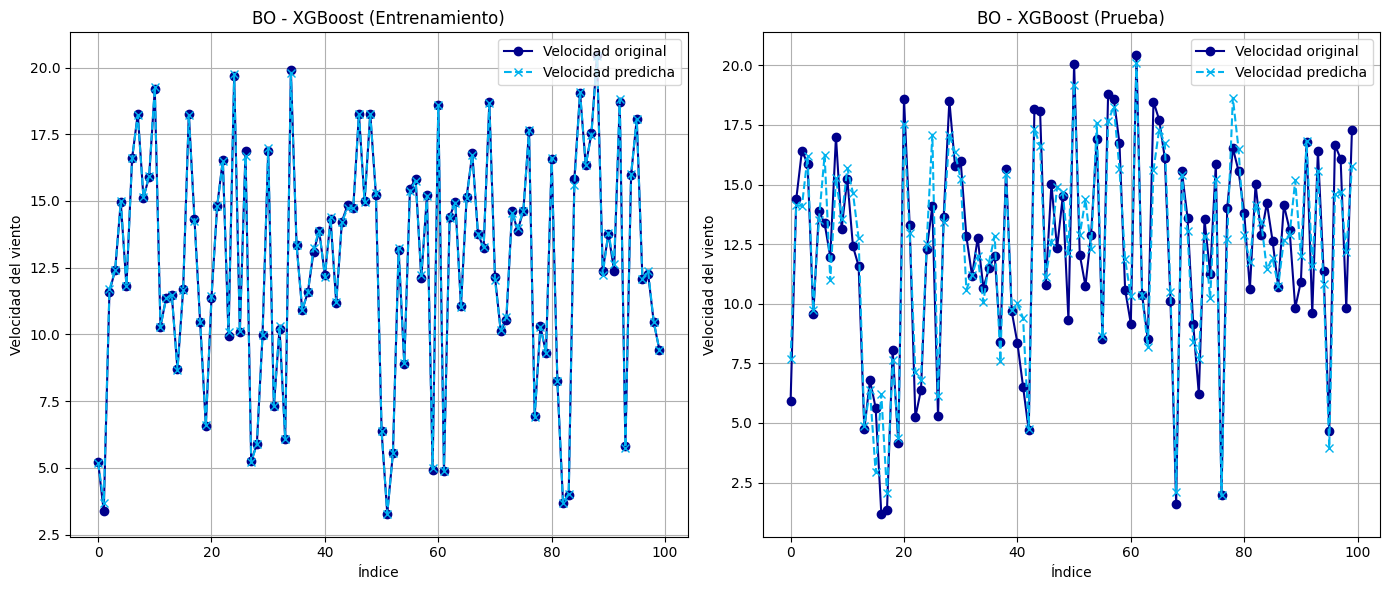

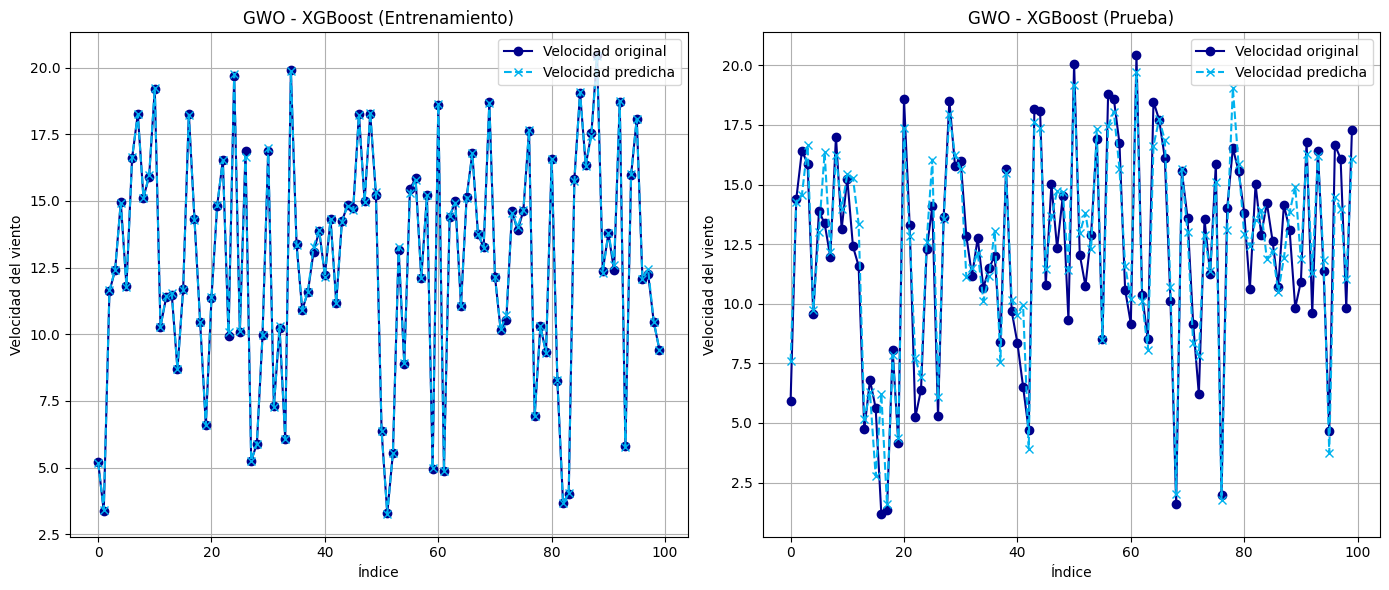

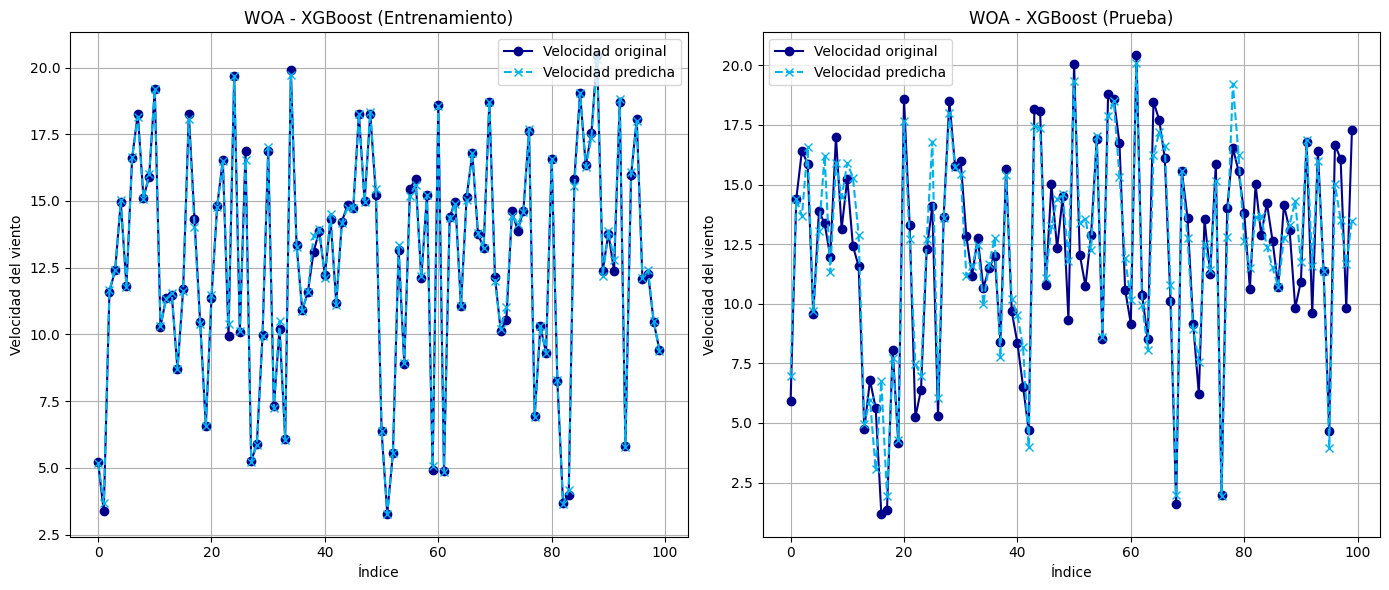

In [41]:
for resultado in resultados_graficos1_original_cargado:
    # Gráfica de predicciones
    grafica(
        resultado['nombre_modelo'],
        resultado['y_train'], resultado['y_train_pred'],
        resultado['y_test'], resultado['y_test_pred']
    )


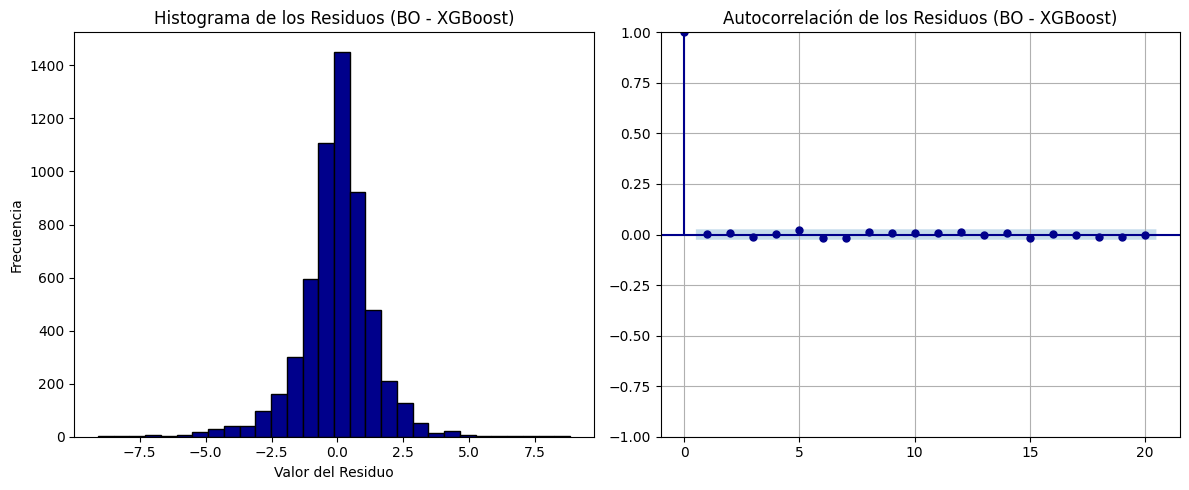

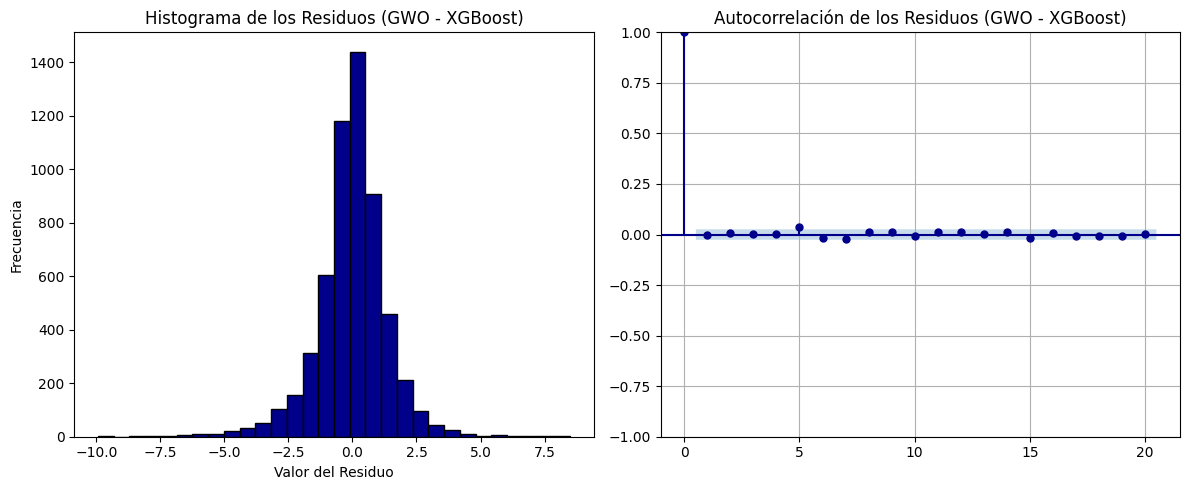

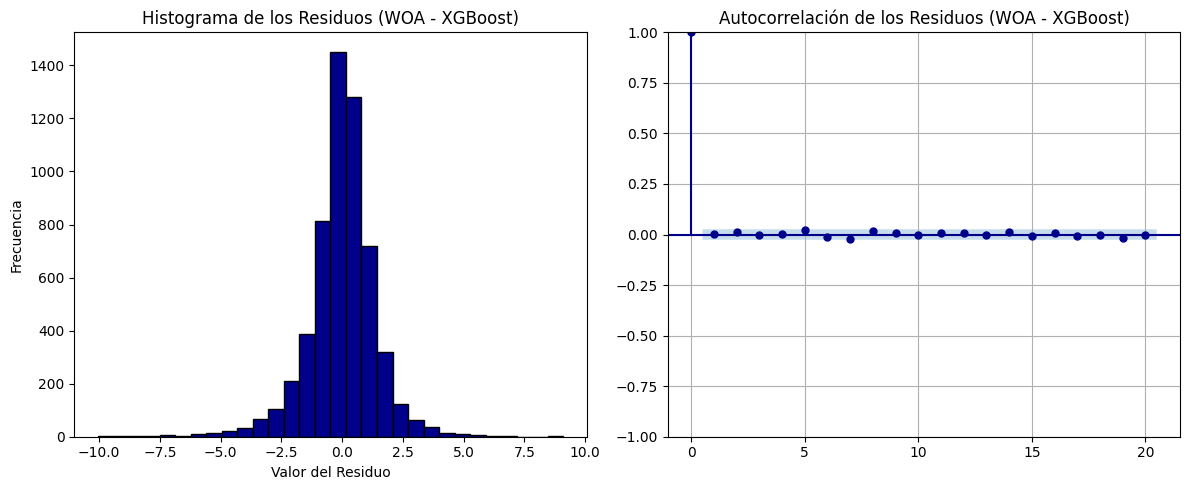

In [42]:
for resultado in resultados_graficos1_original_cargado:
    grafica_residuos(
        resultado['nombre_modelo'],
        resultado['residuos']
    )


## **Modelo 2: Wind speed 100 metros (Sensor 2)**

In [176]:
X2 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento80m', 'DirViento60m'])
y2 = data['VelViento100m_2']

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, random_state = 11)
resultados2 = []
resultados_graficos2 = []

In [177]:
evaluate_bo_xgboost(X_train, y_train, X_test, y_test, resultados2, resultados_graficos2)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.7997    | 0.06228   | 5.292     | 98.01     |
| 2         | 0.8915    | 0.2202    | 11.3      | 102.2     |
| 3         | 0.8617    | 0.01371   | 12.31     | 188.9     |
| 4         | 0.8872    | 0.2567    | 15.95     | 30.66     |
| 5         | 0.8885    | 0.2692    | 17.86     | 41.37     |
| 6         | 0.7939    | 0.1934    | 5.307     | 32.18     |
| 7         | 0.8671    | 0.1017    | 7.369     | 154.2     |
| 8         | 0.8859    | 0.2473    | 10.17     | 70.57     |
| 9         | 0.8221    | 0.04238   | 6.259     | 145.4     |
| 10        | 0.8371    | 0.1839    | 5.835     | 101.2     |
| 11        | 0.8934    | 0.07533   | 13.34     | 104.6     |
| 12        | 0.8917    | 0.1647    | 19.51     | 35.42     |
| 13        | 0.8869    | 0.2987    | 18.35     | 99.76     |
| 14        | 0.8902    | 0.176     | 19.78     | 24.37     |
| 15    

In [178]:
evaluate_gwo_xgboost(X_train, y_train, X_test, y_test, resultados2, resultados_graficos2)

Iteración 1/20: Mejor R² Test = 0.8941178008177226
Iteración 2/20: Mejor R² Test = 0.8960839780915206
Iteración 3/20: Mejor R² Test = 0.8960839780915206
Iteración 4/20: Mejor R² Test = 0.8960839780915206
Iteración 5/20: Mejor R² Test = 0.8960839780915206
Iteración 6/20: Mejor R² Test = 0.8960839780915206
Iteración 7/20: Mejor R² Test = 0.8960839780915206
Iteración 8/20: Mejor R² Test = 0.8960839780915206
Iteración 9/20: Mejor R² Test = 0.8960839780915206
Iteración 10/20: Mejor R² Test = 0.8960839780915206
Iteración 11/20: Mejor R² Test = 0.8960839780915206
Iteración 12/20: Mejor R² Test = 0.8960839780915206
Iteración 13/20: Mejor R² Test = 0.8960839780915206
Iteración 14/20: Mejor R² Test = 0.8960839780915206
Iteración 15/20: Mejor R² Test = 0.8960839780915206
Iteración 16/20: Mejor R² Test = 0.8960839780915206
Iteración 17/20: Mejor R² Test = 0.8960839780915206
Iteración 18/20: Mejor R² Test = 0.8960839780915206
Iteración 19/20: Mejor R² Test = 0.8960839780915206
Iteración 20/20: Mejo

In [179]:
evaluate_woa_xgboost(X_train, y_train, X_test, y_test, resultados2, resultados_graficos2)

Iteración 1/20: Mejor R² Test = 0.8954150027752162
Iteración 2/20: Mejor R² Test = 0.8962053471103358
Iteración 3/20: Mejor R² Test = 0.8963849088084357
Iteración 4/20: Mejor R² Test = 0.897150324491354
Iteración 5/20: Mejor R² Test = 0.897150324491354
Iteración 6/20: Mejor R² Test = 0.897150324491354
Iteración 7/20: Mejor R² Test = 0.897150324491354
Iteración 8/20: Mejor R² Test = 0.897150324491354
Iteración 9/20: Mejor R² Test = 0.897150324491354
Iteración 10/20: Mejor R² Test = 0.897150324491354
Iteración 11/20: Mejor R² Test = 0.897150324491354
Iteración 12/20: Mejor R² Test = 0.897150324491354
Iteración 13/20: Mejor R² Test = 0.897150324491354
Iteración 14/20: Mejor R² Test = 0.897150324491354
Iteración 15/20: Mejor R² Test = 0.897150324491354
Iteración 16/20: Mejor R² Test = 0.897150324491354
Iteración 17/20: Mejor R² Test = 0.897150324491354
Iteración 18/20: Mejor R² Test = 0.897150324491354
Iteración 19/20: Mejor R² Test = 0.897150324491354
Iteración 20/20: Mejor R² Test = 0.89

In [183]:
resultados2 = pd.DataFrame(resultados2)
resultados2

Modelo       MAPE       MAE       MSE      RMSE        R²  \
0   BO - XGBoost  11.665009  0.960555  1.985226  1.408980  0.893566   
1  GWO - XGBoost  11.583920  0.949993  1.938268  1.392217  0.896084   
2  WOA - XGBoost  11.474580  0.957150  1.918378  1.385055  0.897150   

   Ljung-Box p-value  Jarque-Bera p-value  Tiempo de ejecución (s)  
0           0.268434                  0.0                55.526932  
1           0.191063                  0.0               194.137552  
2           0.199882                  0.0               441.804543

In [ ]:
resultados2.to_pickle('resultados2_original.pkl')

with open('resultados_graficos2_original.pkl', 'wb') as file:
    pickle.dump(resultados_graficos2, file)

In [ ]:
with open('resultados_graficos2_original.pkl', 'rb') as file:
    resultados_graficos2_original_cargado = pickle.load(file)

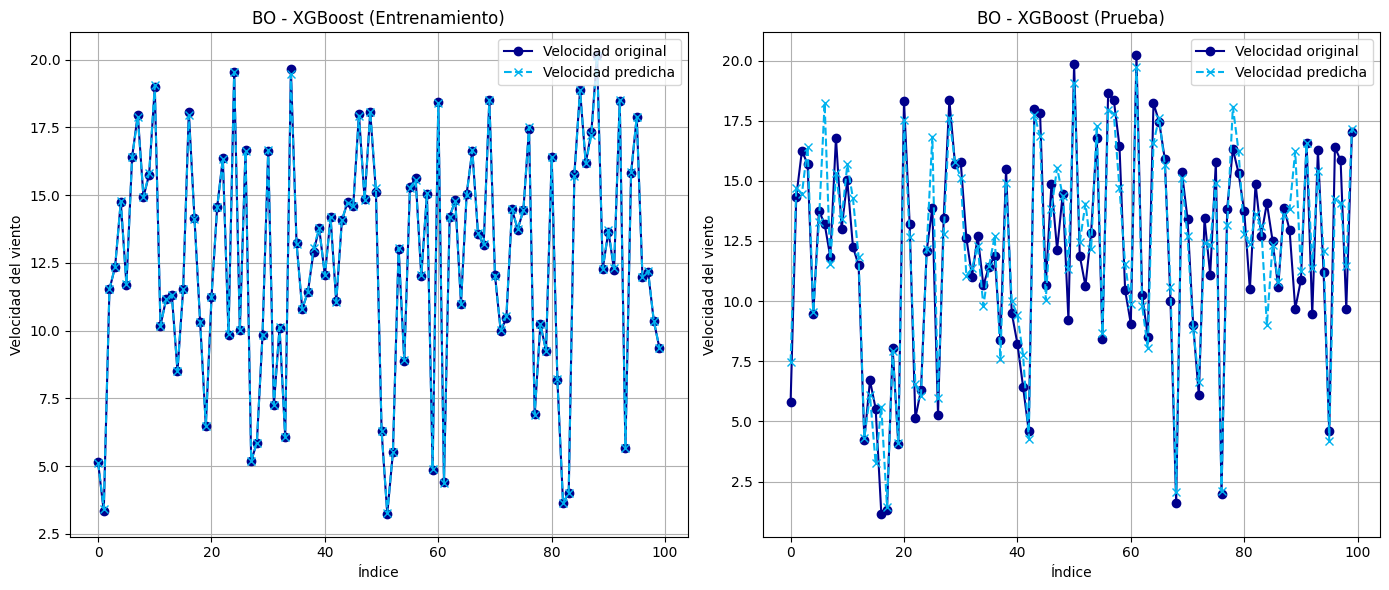

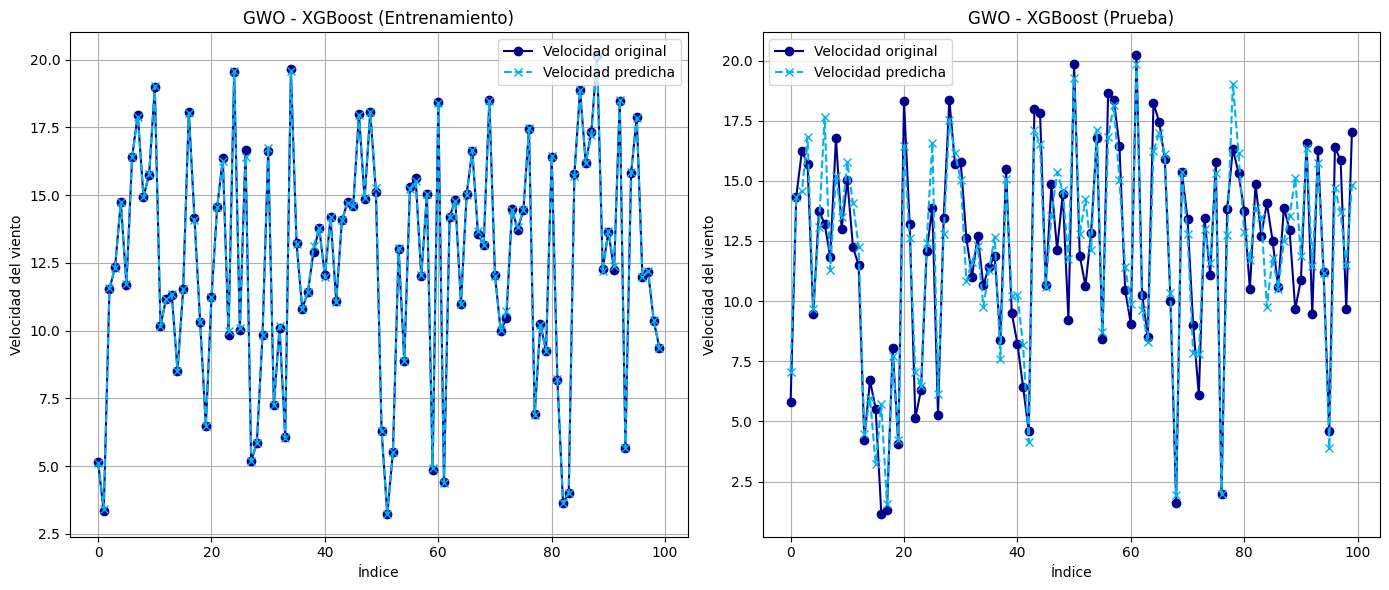

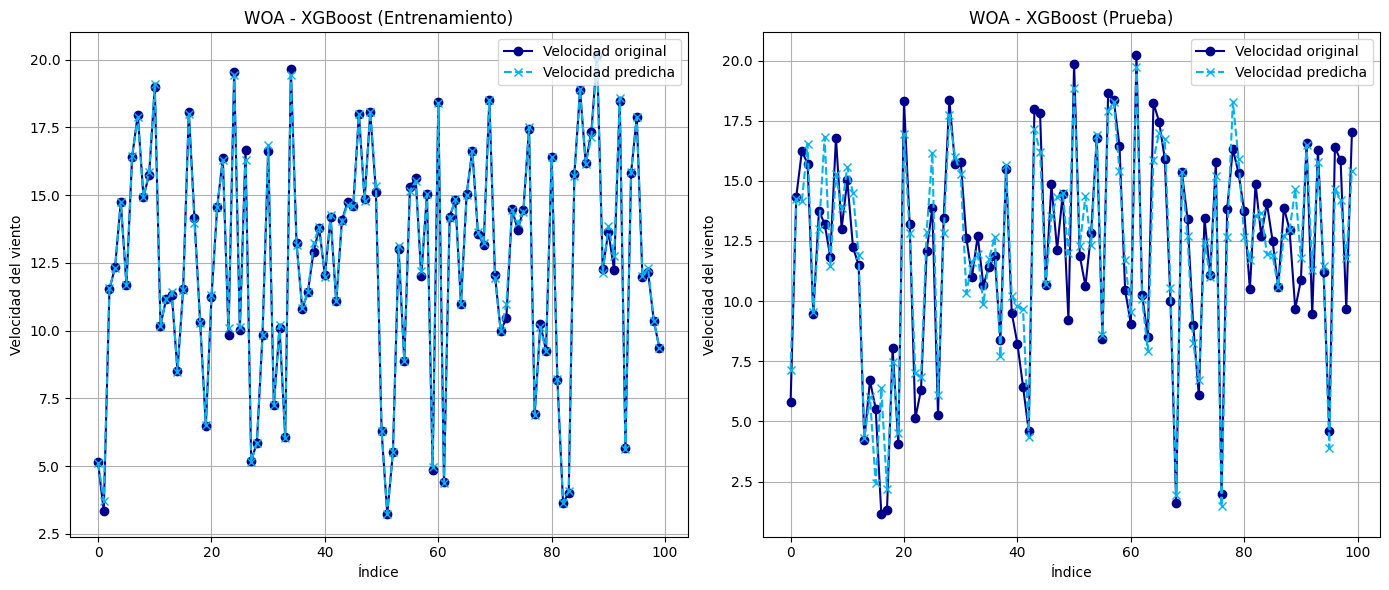

In [44]:
for resultado in resultados_graficos2_original_cargado:
    # Gráfica de predicciones
    grafica(
        resultado['nombre_modelo'],
        resultado['y_train'], resultado['y_train_pred'],
        resultado['y_test'], resultado['y_test_pred']
    )

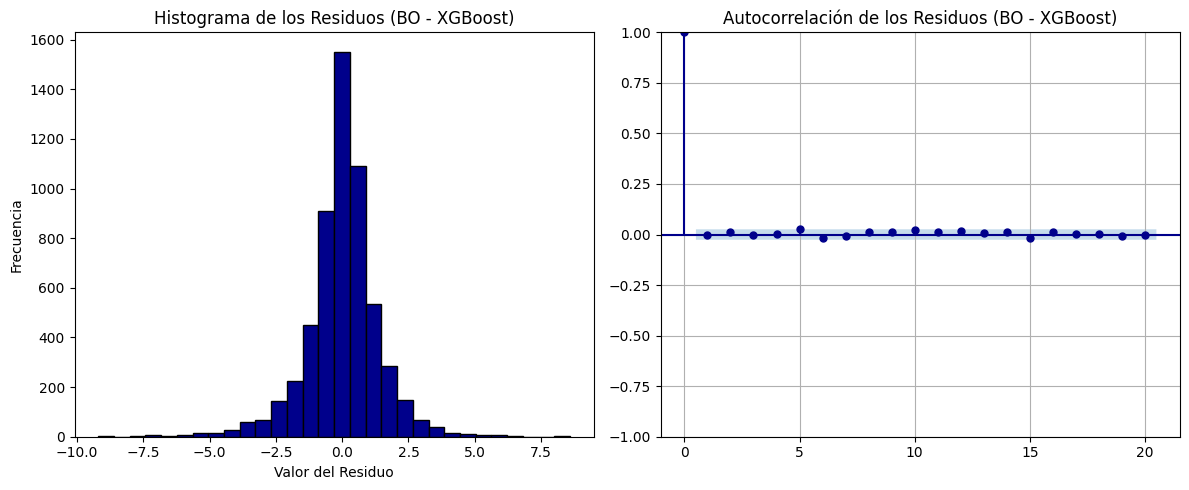

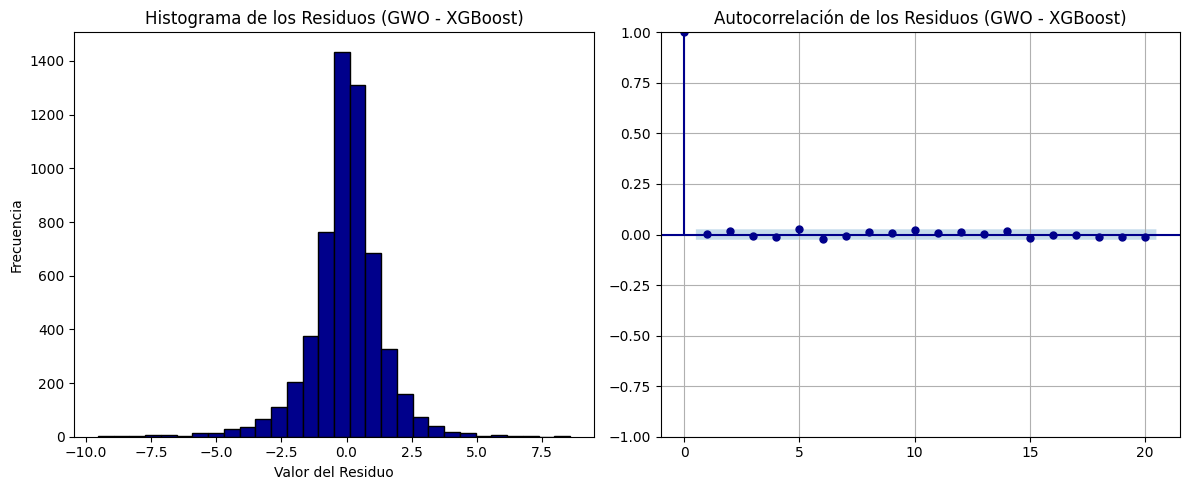

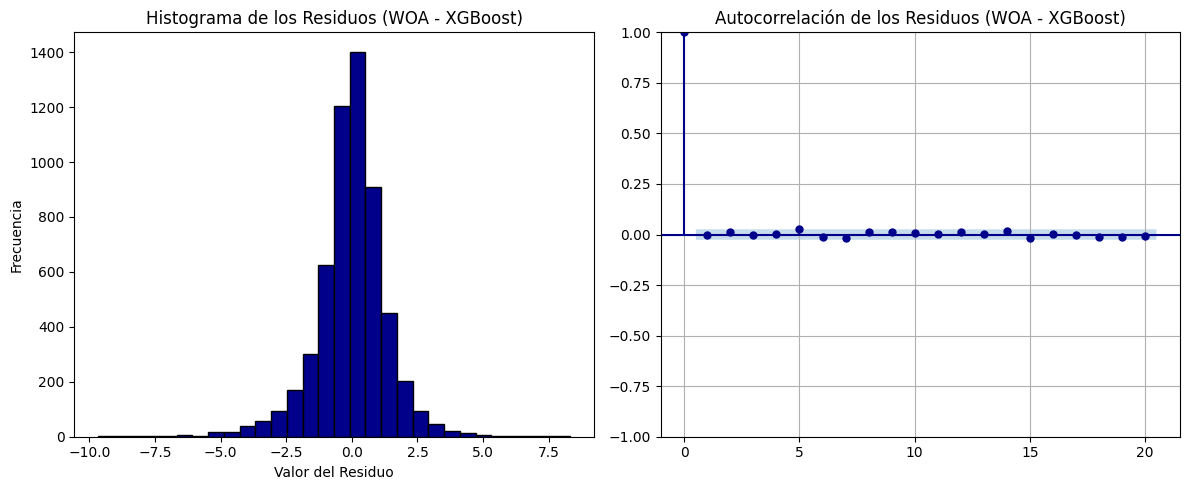

In [45]:
for resultado in resultados_graficos2_original_cargado:
    grafica_residuos(
        resultado['nombre_modelo'],
        resultado['residuos']
    )

## **Modelo 3: Wind speed 80 metros (Sensor 1)**

In [185]:
X3 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento100m', 'DirViento60m'])
y3 = data['VelViento80m_1']

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.3, random_state = 11)
resultados3 = []
resultados_graficos3 = []

In [186]:
evaluate_bo_xgboost(X_train, y_train, X_test, y_test, resultados3, resultados_graficos3)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.7983    | 0.06228   | 5.292     | 98.01     |
| 2         | 0.8866    | 0.2202    | 11.3      | 102.2     |
| 3         | 0.8602    | 0.01371   | 12.31     | 188.9     |
| 4         | 0.8834    | 0.2567    | 15.95     | 30.66     |
| 5         | 0.8834    | 0.2692    | 17.86     | 41.37     |
| 6         | 0.7978    | 0.1934    | 5.307     | 32.18     |
| 7         | 0.8656    | 0.1017    | 7.369     | 154.2     |
| 8         | 0.8877    | 0.2473    | 10.17     | 70.57     |
| 9         | 0.8222    | 0.04238   | 6.259     | 145.4     |
| 10        | 0.8362    | 0.1839    | 5.835     | 101.2     |
| 11        | 0.8887    | 0.1413    | 12.62     | 68.68     |
| 12        | 0.8835    | 0.2676    | 18.7      | 35.83     |
| 13        | 0.8913    | 0.1639    | 13.37     | 107.8     |
| 14        | 0.8807    | 0.2672    | 19.22     | 103.2     |
| 15    

In [187]:
evaluate_gwo_xgboost(X_train, y_train, X_test, y_test, resultados3, resultados_graficos3)

Iteración 1/20: Mejor R² Test = 0.8920811245105431
Iteración 2/20: Mejor R² Test = 0.8939155485319163
Iteración 3/20: Mejor R² Test = 0.8939155485319163
Iteración 4/20: Mejor R² Test = 0.8939155485319163
Iteración 5/20: Mejor R² Test = 0.8941624369773589
Iteración 6/20: Mejor R² Test = 0.8941624369773589
Iteración 7/20: Mejor R² Test = 0.8941624369773589
Iteración 8/20: Mejor R² Test = 0.8941624369773589
Iteración 9/20: Mejor R² Test = 0.8941624369773589
Iteración 10/20: Mejor R² Test = 0.8941624369773589
Iteración 11/20: Mejor R² Test = 0.8944991388468198
Iteración 12/20: Mejor R² Test = 0.8944991388468198
Iteración 13/20: Mejor R² Test = 0.8944991388468198
Iteración 14/20: Mejor R² Test = 0.8944991388468198
Iteración 15/20: Mejor R² Test = 0.8944991388468198
Iteración 16/20: Mejor R² Test = 0.8944991388468198
Iteración 17/20: Mejor R² Test = 0.8944991388468198
Iteración 18/20: Mejor R² Test = 0.8944991388468198
Iteración 19/20: Mejor R² Test = 0.8944991388468198
Iteración 20/20: Mejo

In [188]:
evaluate_woa_xgboost(X_train, y_train, X_test, y_test, resultados3, resultados_graficos3)

Iteración 1/20: Mejor R² Test = 0.8920811245105431
Iteración 2/20: Mejor R² Test = 0.8920811245105431
Iteración 3/20: Mejor R² Test = 0.8920811245105431
Iteración 4/20: Mejor R² Test = 0.8932286961585281
Iteración 5/20: Mejor R² Test = 0.8932286961585281
Iteración 6/20: Mejor R² Test = 0.8932286961585281
Iteración 7/20: Mejor R² Test = 0.8932286961585281
Iteración 8/20: Mejor R² Test = 0.8932286961585281
Iteración 9/20: Mejor R² Test = 0.8932286961585281
Iteración 10/20: Mejor R² Test = 0.8932286961585281
Iteración 11/20: Mejor R² Test = 0.8932286961585281
Iteración 12/20: Mejor R² Test = 0.8932286961585281
Iteración 13/20: Mejor R² Test = 0.8932286961585281
Iteración 14/20: Mejor R² Test = 0.8932286961585281
Iteración 15/20: Mejor R² Test = 0.8932286961585281
Iteración 16/20: Mejor R² Test = 0.8932286961585281
Iteración 17/20: Mejor R² Test = 0.8932286961585281
Iteración 18/20: Mejor R² Test = 0.8932286961585281
Iteración 19/20: Mejor R² Test = 0.8932286961585281
Iteración 20/20: Mejo

In [189]:
resultados3 = pd.DataFrame(resultados3)
resultados3

Modelo       MAPE       MAE       MSE      RMSE        R²  \
0   BO - XGBoost  12.042949  0.970808  1.893165  1.375923  0.892765   
1  GWO - XGBoost  12.076212  0.952756  1.862555  1.364754  0.894499   
2  WOA - XGBoost  11.842134  0.955850  1.884984  1.372947  0.893229   

   Ljung-Box p-value  Jarque-Bera p-value  Tiempo de ejecución (s)  
0           0.560461                  0.0                48.603204  
1           0.555796                  0.0               157.250019  
2           0.589736                  0.0               281.519942

In [ ]:
resultados3.to_pickle('resultados3_original.pkl')
with open('resultados_graficos3_original.pkl', 'wb') as file:
    pickle.dump(resultados_graficos3, file)

In [46]:
with open('resultados_graficos3_original.pkl', 'rb') as file:
    resultados_graficos3_original_cargado = pickle.load(file)

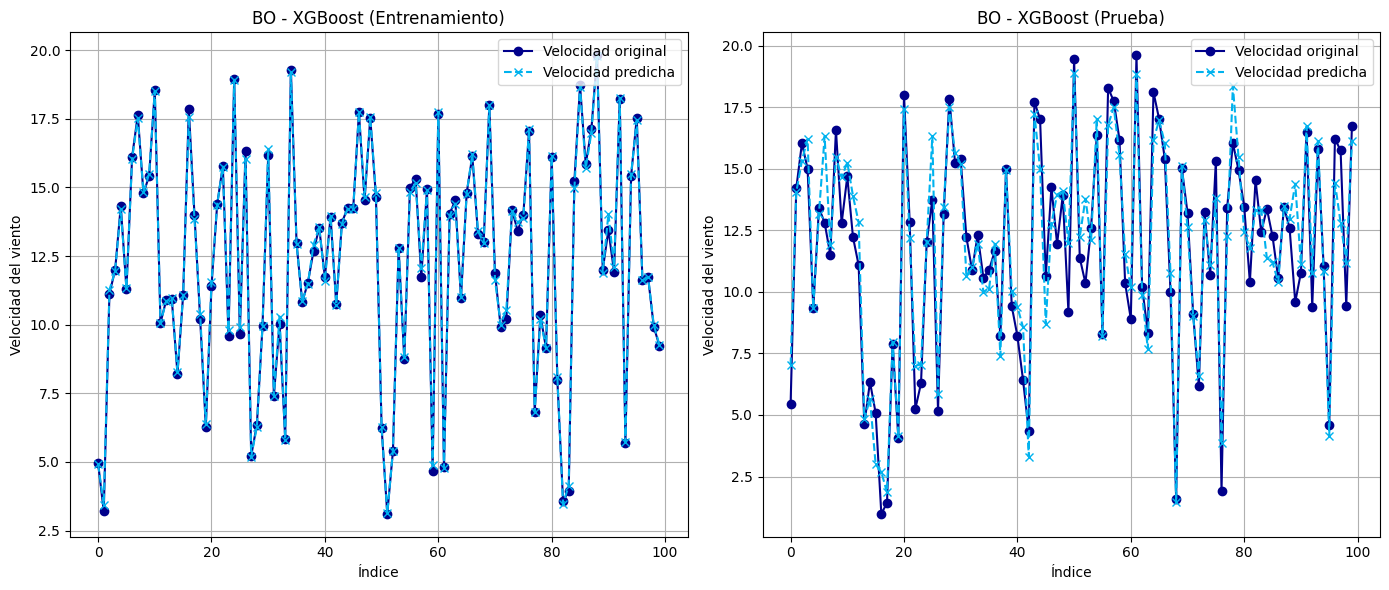

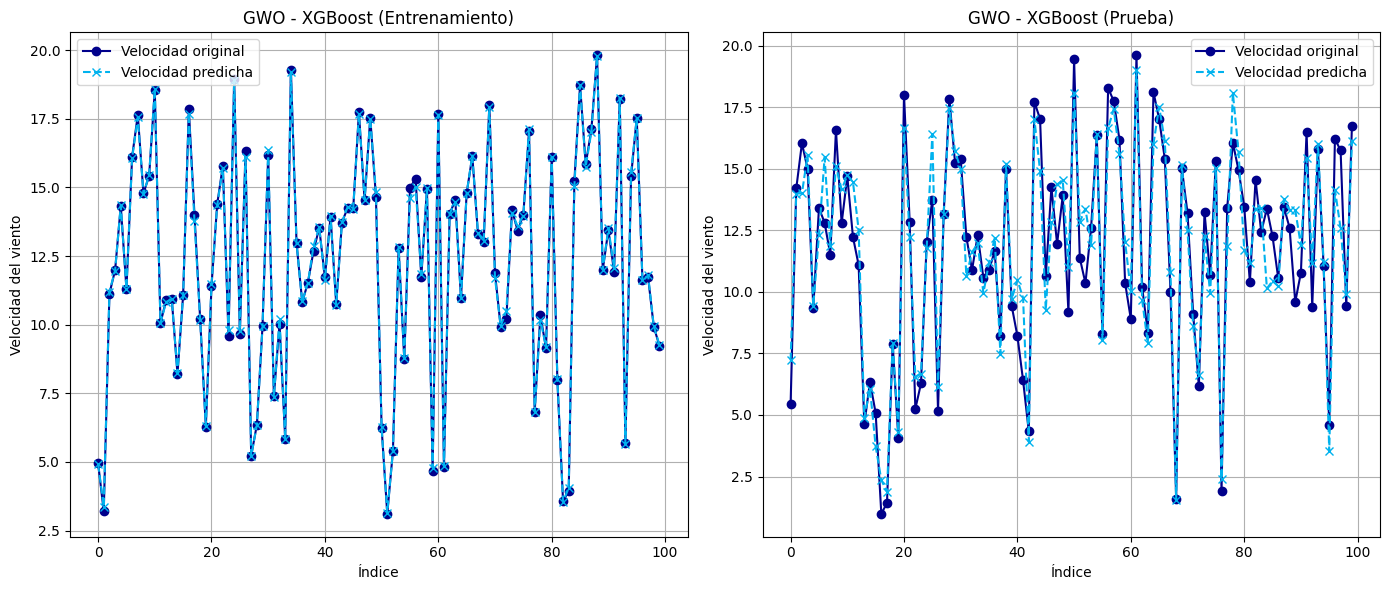

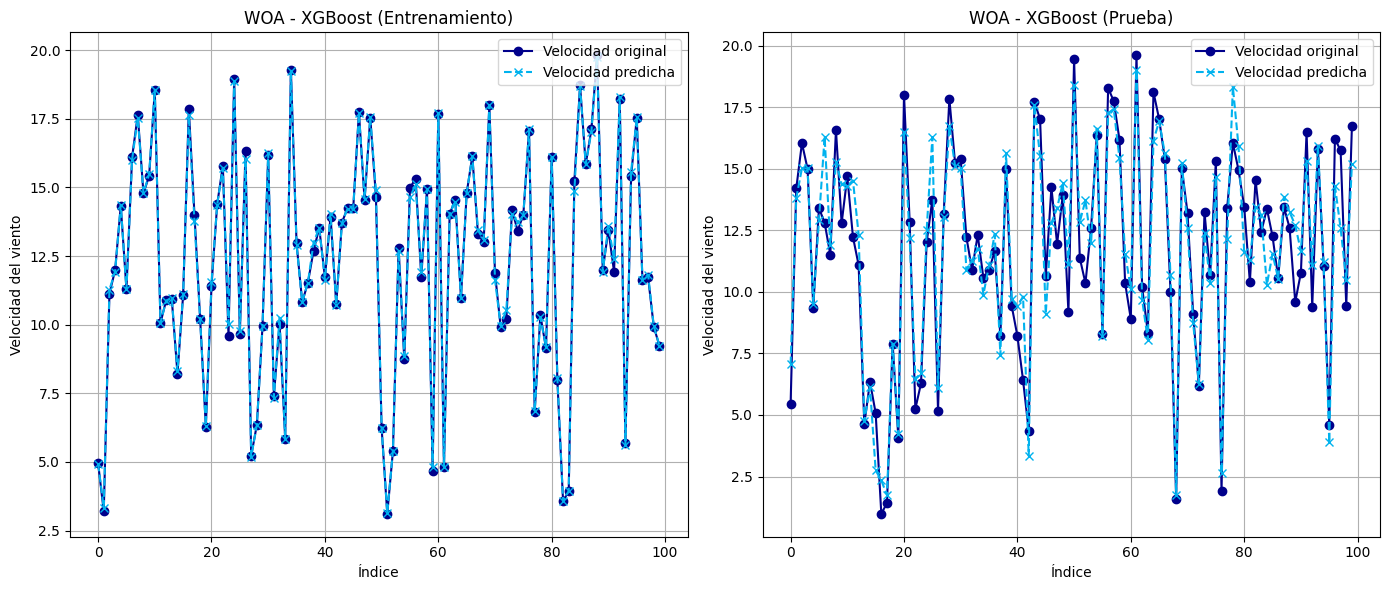

In [47]:
for resultado in resultados_graficos3_original_cargado:
    # Gráfica de predicciones
    grafica(
        resultado['nombre_modelo'],
        resultado['y_train'], resultado['y_train_pred'],
        resultado['y_test'], resultado['y_test_pred']
    )

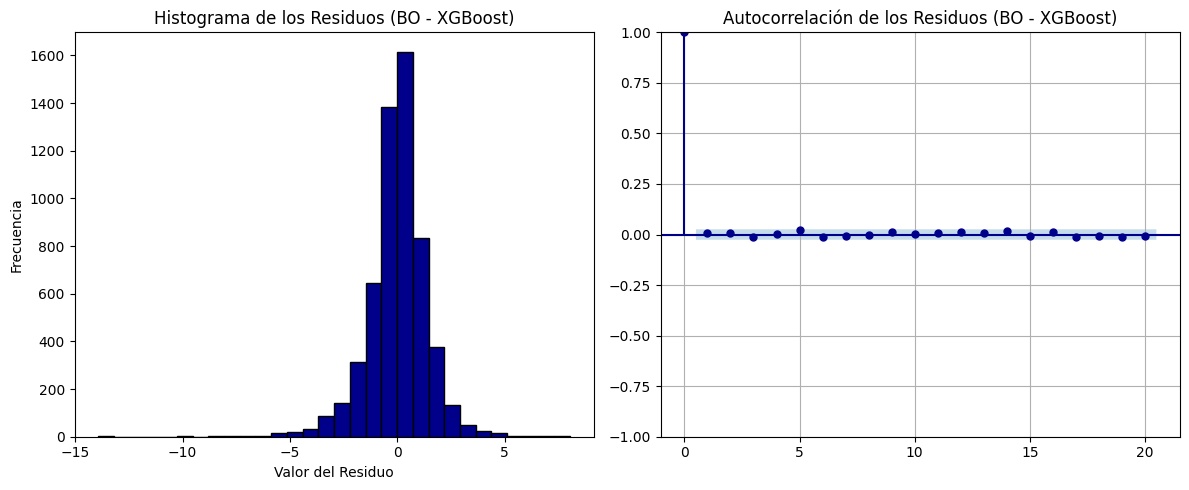

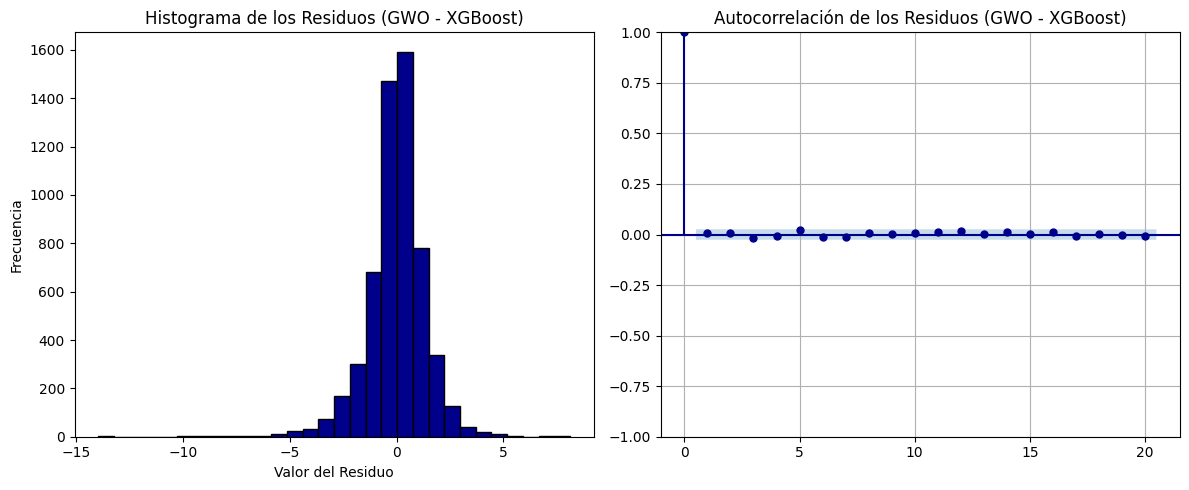

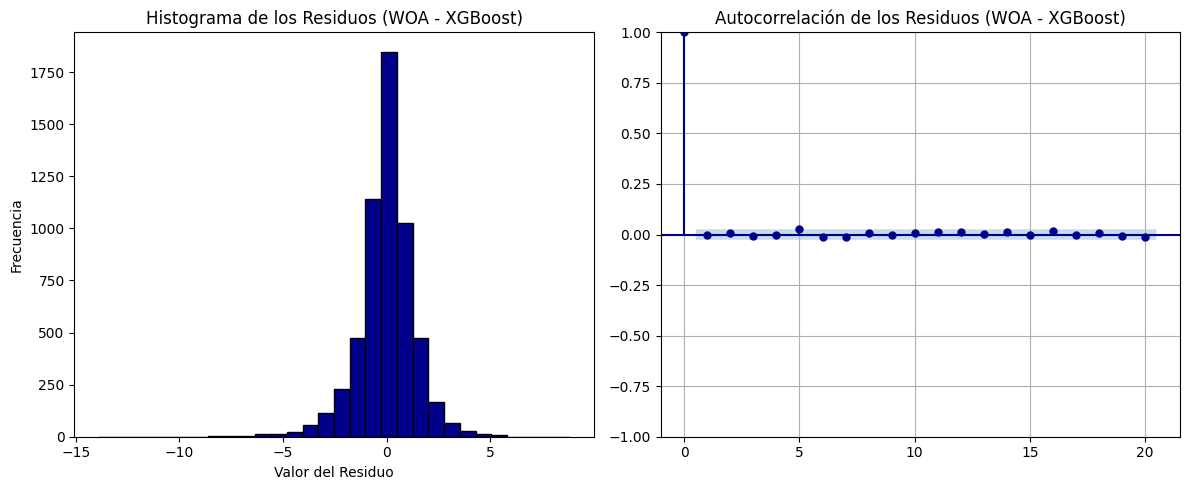

In [48]:
for resultado in resultados_graficos3_original_cargado:
    grafica_residuos(
        resultado['nombre_modelo'],
        resultado['residuos']
    )

## **Modelo 4: Wind speed 80 metros (Sensor 2)**

In [192]:
X4 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento100m', 'DirViento60m'])
y4 = data['VelViento80m_2']

X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size = 0.3, random_state = 11)
resultados4 = []
resultados_graficos4 = []

In [193]:
evaluate_bo_xgboost(X_train, y_train, X_test, y_test, resultados4, resultados_graficos4)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.7987    | 0.06228   | 5.292     | 98.01     |
| 2         | 0.8886    | 0.2202    | 11.3      | 102.2     |
| 3         | 0.8603    | 0.01371   | 12.31     | 188.9     |
| 4         | 0.8829    | 0.2567    | 15.95     | 30.66     |
| 5         | 0.8844    | 0.2692    | 17.86     | 41.37     |
| 6         | 0.7948    | 0.1934    | 5.307     | 32.18     |
| 7         | 0.8677    | 0.1017    | 7.369     | 154.2     |
| 8         | 0.8849    | 0.2473    | 10.17     | 70.57     |
| 9         | 0.8211    | 0.04238   | 6.259     | 145.4     |
| 10        | 0.8373    | 0.1839    | 5.835     | 101.2     |
| 11        | 0.8907    | 0.2105    | 13.73     | 104.0     |
| 12        | 0.881     | 0.1647    | 19.51     | 35.42     |
| 13        | 0.8823    | 0.07403   | 10.1      | 108.5     |
| 14        | 0.8795    | 0.0775    | 11.77     | 63.14     |
| 15    

In [194]:
evaluate_gwo_xgboost(X_train, y_train, X_test, y_test, resultados4, resultados_graficos4)

Iteración 1/20: Mejor R² Test = 0.8908026633136267
Iteración 2/20: Mejor R² Test = 0.8934893633064818
Iteración 3/20: Mejor R² Test = 0.8934893633064818
Iteración 4/20: Mejor R² Test = 0.8934893633064818
Iteración 5/20: Mejor R² Test = 0.8934893633064818
Iteración 6/20: Mejor R² Test = 0.8938473002611507
Iteración 7/20: Mejor R² Test = 0.8938473002611507
Iteración 8/20: Mejor R² Test = 0.8938473002611507
Iteración 9/20: Mejor R² Test = 0.8938473002611507
Iteración 10/20: Mejor R² Test = 0.8938473002611507
Iteración 11/20: Mejor R² Test = 0.8938473002611507
Iteración 12/20: Mejor R² Test = 0.8938473002611507
Iteración 13/20: Mejor R² Test = 0.8938473002611507
Iteración 14/20: Mejor R² Test = 0.8938473002611507
Iteración 15/20: Mejor R² Test = 0.8938473002611507
Iteración 16/20: Mejor R² Test = 0.8938473002611507
Iteración 17/20: Mejor R² Test = 0.8938473002611507
Iteración 18/20: Mejor R² Test = 0.8938473002611507
Iteración 19/20: Mejor R² Test = 0.8938473002611507
Iteración 20/20: Mejo

In [195]:
evaluate_woa_xgboost(X_train, y_train, X_test, y_test, resultados4, resultados_graficos4)

Iteración 1/20: Mejor R² Test = 0.8908026633136267
Iteración 2/20: Mejor R² Test = 0.891955951627562
Iteración 3/20: Mejor R² Test = 0.8922176724994384
Iteración 4/20: Mejor R² Test = 0.8922176724994384
Iteración 5/20: Mejor R² Test = 0.8922176724994384
Iteración 6/20: Mejor R² Test = 0.8922176724994384
Iteración 7/20: Mejor R² Test = 0.8922176724994384
Iteración 8/20: Mejor R² Test = 0.8922176724994384
Iteración 9/20: Mejor R² Test = 0.8922176724994384
Iteración 10/20: Mejor R² Test = 0.8922176724994384
Iteración 11/20: Mejor R² Test = 0.8922176724994384
Iteración 12/20: Mejor R² Test = 0.8922176724994384
Iteración 13/20: Mejor R² Test = 0.8922176724994384
Iteración 14/20: Mejor R² Test = 0.8922176724994384
Iteración 15/20: Mejor R² Test = 0.8922176724994384
Iteración 16/20: Mejor R² Test = 0.8922176724994384
Iteración 17/20: Mejor R² Test = 0.8922176724994384
Iteración 18/20: Mejor R² Test = 0.8922176724994384
Iteración 19/20: Mejor R² Test = 0.8922176724994384
Iteración 20/20: Mejor

In [196]:
resultados4 = pd.DataFrame(resultados4)
resultados4

Modelo       MAPE       MAE       MSE      RMSE        R²  \
0   BO - XGBoost  12.194524  0.966684  1.920801  1.385929  0.890699   
1  GWO - XGBoost  12.076600  0.966446  1.865466  1.365821  0.893847   
2  WOA - XGBoost  12.053123  0.969825  1.894104  1.376265  0.892218   

   Ljung-Box p-value  Jarque-Bera p-value  Tiempo de ejecución (s)  
0           0.182821                  0.0                52.236629  
1           0.779159                  0.0               395.892206  
2           0.827329                  0.0               129.163316

In [ ]:
resultados4.to_pickle('resultados4_original.pkl')
with open('resultados_graficos4_original.pkl', 'wb') as file:
    pickle.dump(resultados_graficos4, file)

In [49]:
with open('resultados_graficos4_original.pkl', 'rb') as file:
    resultados_graficos4_original_cargado = pickle.load(file)

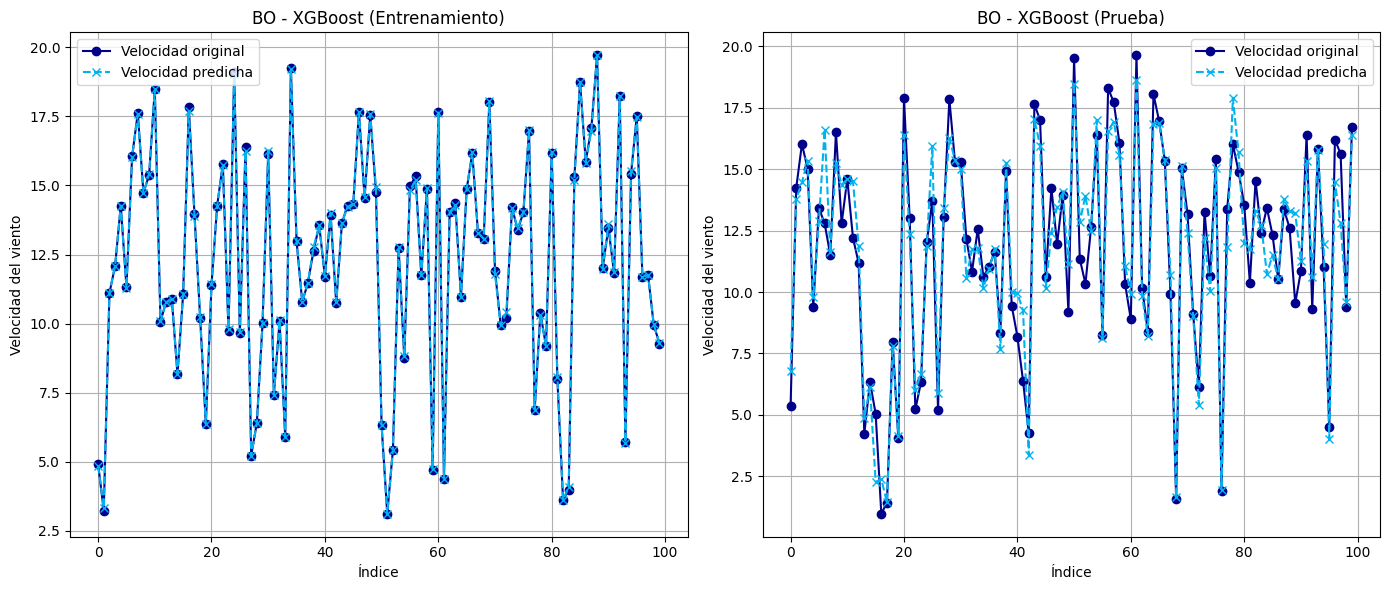

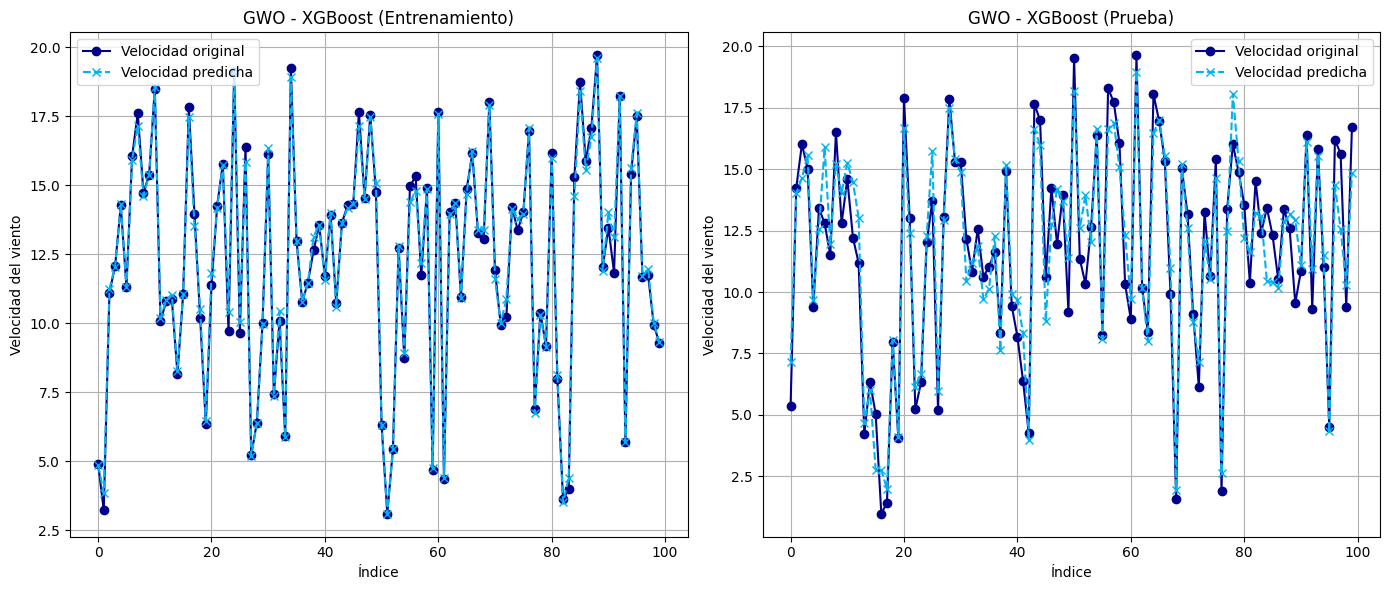

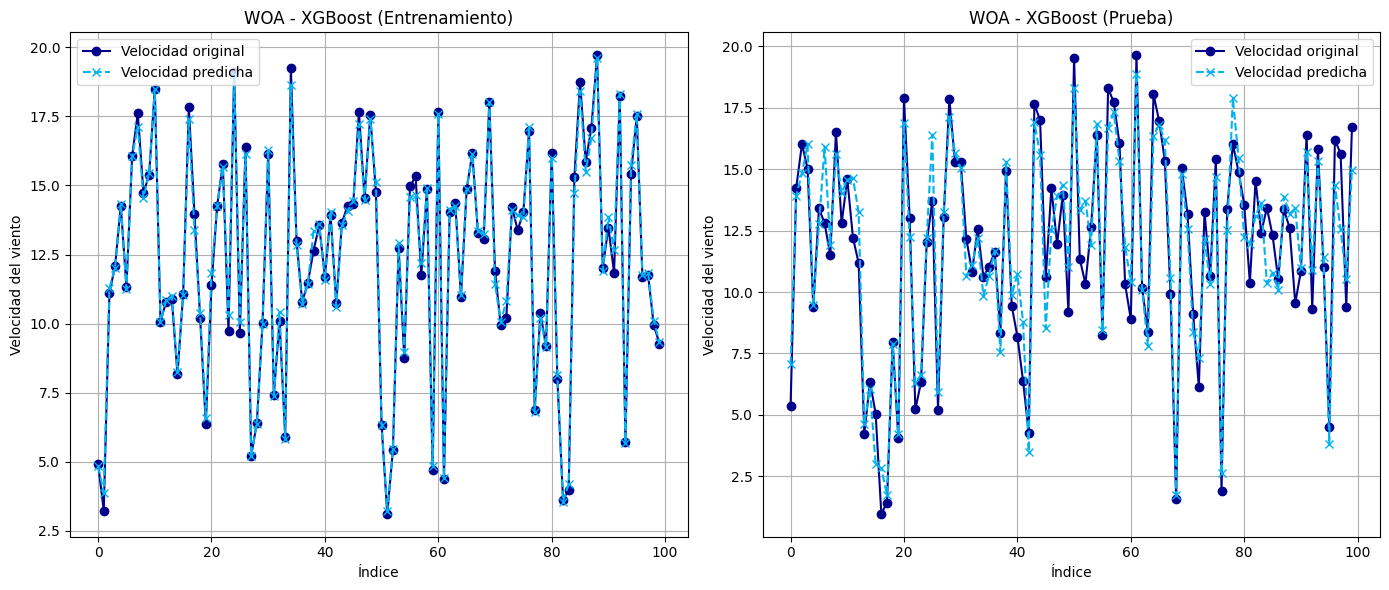

In [50]:
for resultado in resultados_graficos4_original_cargado:
    # Gráfica de predicciones
    grafica(
        resultado['nombre_modelo'],
        resultado['y_train'], resultado['y_train_pred'],
        resultado['y_test'], resultado['y_test_pred']
    )

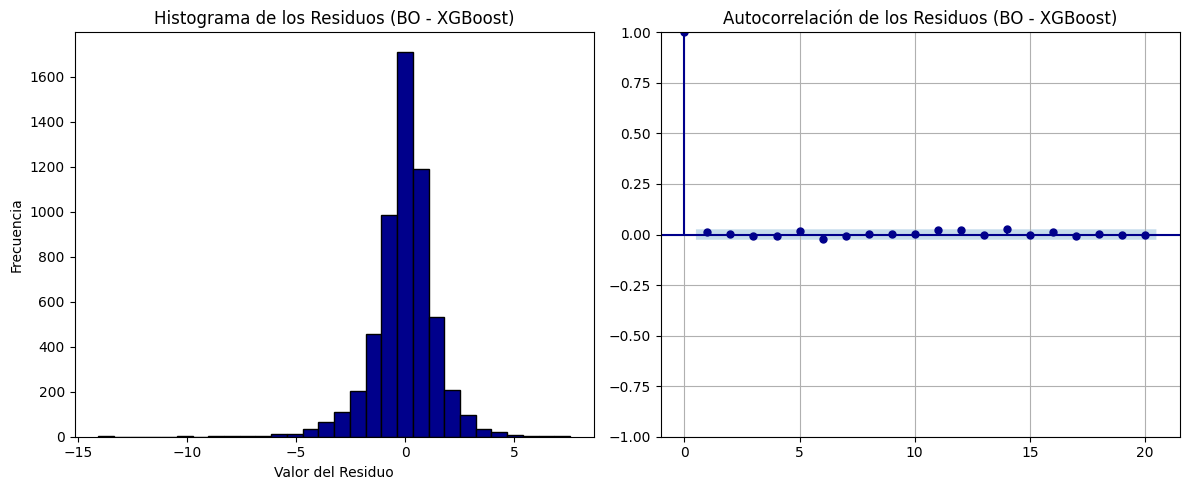

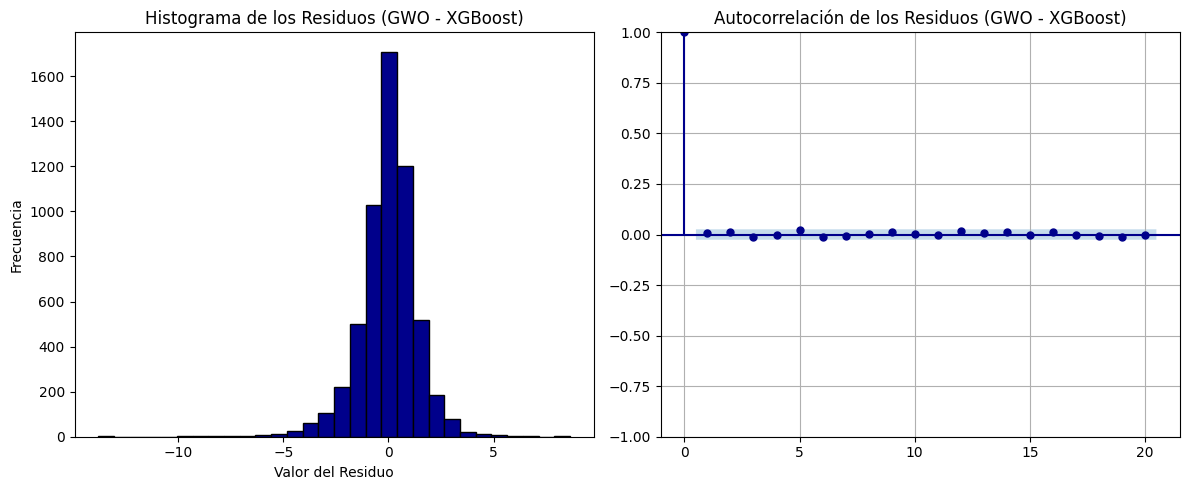

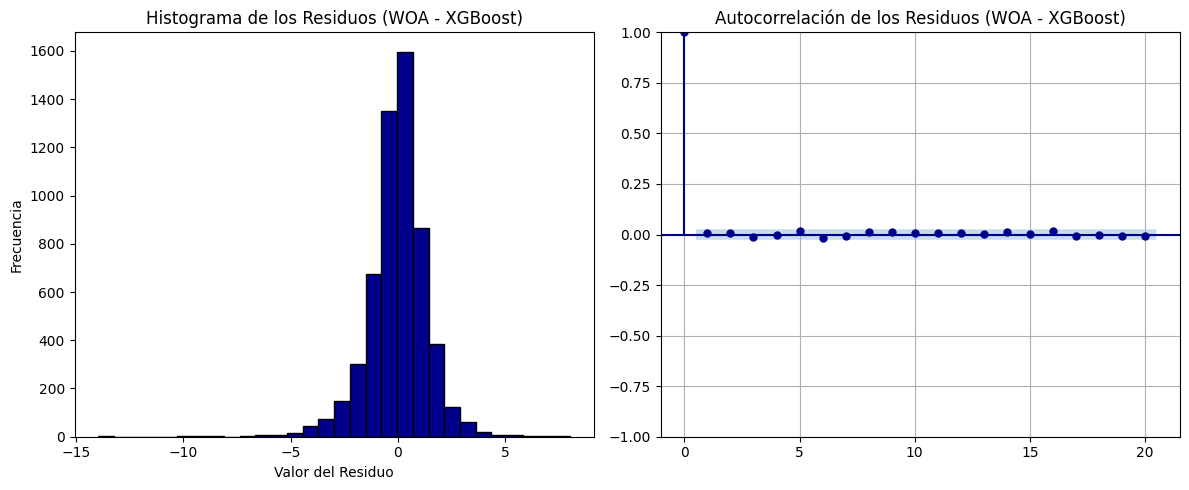

In [51]:
for resultado in resultados_graficos4_original_cargado:
    grafica_residuos(
        resultado['nombre_modelo'],
        resultado['residuos']
    )

## **Modelo 5: Wind speed 60 metros**

In [198]:
X5 = data.drop(columns=['Fecha', 'VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'VelViento60m', 'DirViento80m', 'DirViento100m'])
y5 = data['VelViento60m']


X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size = 0.3, random_state = 11)
resultados5 = []
resultados_graficos5 = []

In [199]:
evaluate_bo_xgboost(X_train, y_train, X_test, y_test, resultados5, resultados_graficos5)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.8001    | 0.06228   | 5.292     | 98.01     |
| 2         | 0.8895    | 0.2202    | 11.3      | 102.2     |
| 3         | 0.8617    | 0.01371   | 12.31     | 188.9     |
| 4         | 0.8864    | 0.2567    | 15.95     | 30.66     |
| 5         | 0.8866    | 0.2692    | 17.86     | 41.37     |
| 6         | 0.7994    | 0.1934    | 5.307     | 32.18     |
| 7         | 0.8683    | 0.1017    | 7.369     | 154.2     |
| 8         | 0.8877    | 0.2473    | 10.17     | 70.57     |
| 9         | 0.8229    | 0.04238   | 6.259     | 145.4     |
| 10        | 0.8365    | 0.1839    | 5.835     | 101.2     |
| 11        | 0.8917    | 0.07533   | 13.34     | 104.6     |
| 12        | 0.8863    | 0.1647    | 19.51     | 35.42     |
| 13        | 0.8906    | 0.1219    | 18.0      | 100.1     |
| 14        | 0.887     | 0.176     | 19.78     | 24.37     |
| 15    

In [200]:
evaluate_gwo_xgboost(X_train, y_train, X_test, y_test, resultados5, resultados_graficos5)

Iteración 1/20: Mejor R² Test = 0.895505468773704
Iteración 2/20: Mejor R² Test = 0.895505468773704
Iteración 3/20: Mejor R² Test = 0.895505468773704
Iteración 4/20: Mejor R² Test = 0.895505468773704
Iteración 5/20: Mejor R² Test = 0.895505468773704
Iteración 6/20: Mejor R² Test = 0.895505468773704
Iteración 7/20: Mejor R² Test = 0.895505468773704
Iteración 8/20: Mejor R² Test = 0.895505468773704
Iteración 9/20: Mejor R² Test = 0.895505468773704
Iteración 10/20: Mejor R² Test = 0.895505468773704
Iteración 11/20: Mejor R² Test = 0.895505468773704
Iteración 12/20: Mejor R² Test = 0.895505468773704
Iteración 13/20: Mejor R² Test = 0.895505468773704
Iteración 14/20: Mejor R² Test = 0.895505468773704
Iteración 15/20: Mejor R² Test = 0.895505468773704
Iteración 16/20: Mejor R² Test = 0.895505468773704
Iteración 17/20: Mejor R² Test = 0.895505468773704
Iteración 18/20: Mejor R² Test = 0.895505468773704
Iteración 19/20: Mejor R² Test = 0.895505468773704
Iteración 20/20: Mejor R² Test = 0.89550

In [201]:
evaluate_woa_xgboost(X_train, y_train, X_test, y_test, resultados5, resultados_graficos5)

Iteración 1/20: Mejor R² Test = 0.895505468773704
Iteración 2/20: Mejor R² Test = 0.8959620826726546
Iteración 3/20: Mejor R² Test = 0.8959620826726546
Iteración 4/20: Mejor R² Test = 0.8959620826726546
Iteración 5/20: Mejor R² Test = 0.8959620826726546
Iteración 6/20: Mejor R² Test = 0.8959620826726546
Iteración 7/20: Mejor R² Test = 0.8960011826300844
Iteración 8/20: Mejor R² Test = 0.8960011826300844
Iteración 9/20: Mejor R² Test = 0.8965046644435989
Iteración 10/20: Mejor R² Test = 0.8965046644435989
Iteración 11/20: Mejor R² Test = 0.8965046644435989
Iteración 12/20: Mejor R² Test = 0.8965046644435989
Iteración 13/20: Mejor R² Test = 0.8965046644435989
Iteración 14/20: Mejor R² Test = 0.8965046644435989
Iteración 15/20: Mejor R² Test = 0.8965046644435989
Iteración 16/20: Mejor R² Test = 0.8965046644435989
Iteración 17/20: Mejor R² Test = 0.8965046644435989
Iteración 18/20: Mejor R² Test = 0.8965046644435989
Iteración 19/20: Mejor R² Test = 0.8965046644435989
Iteración 20/20: Mejor

In [202]:
resultados5 = pd.DataFrame(resultados5) 
resultados5

Modelo       MAPE       MAE       MSE      RMSE        R²  \
0   BO - XGBoost  11.168980  0.925260  1.710543  1.307877  0.895147   
1  GWO - XGBoost  11.242660  0.926778  1.704697  1.305640  0.895505   
2  WOA - XGBoost  11.274699  0.927149  1.688396  1.299383  0.896505   

   Ljung-Box p-value  Jarque-Bera p-value  Tiempo de ejecución (s)  
0           0.588636                  0.0                85.352890  
1           0.409678                  0.0               622.426271  
2           0.703850                  0.0               950.474232

In [ ]:
resultados5.to_pickle('resultados5_original.pkl')
with open('resultados_graficos5_original.pkl', 'wb') as file:
    pickle.dump(resultados_graficos5, file)

In [52]:
with open('resultados_graficos5_original.pkl', 'rb') as file:
    resultados_graficos5_original_cargado = pickle.load(file)

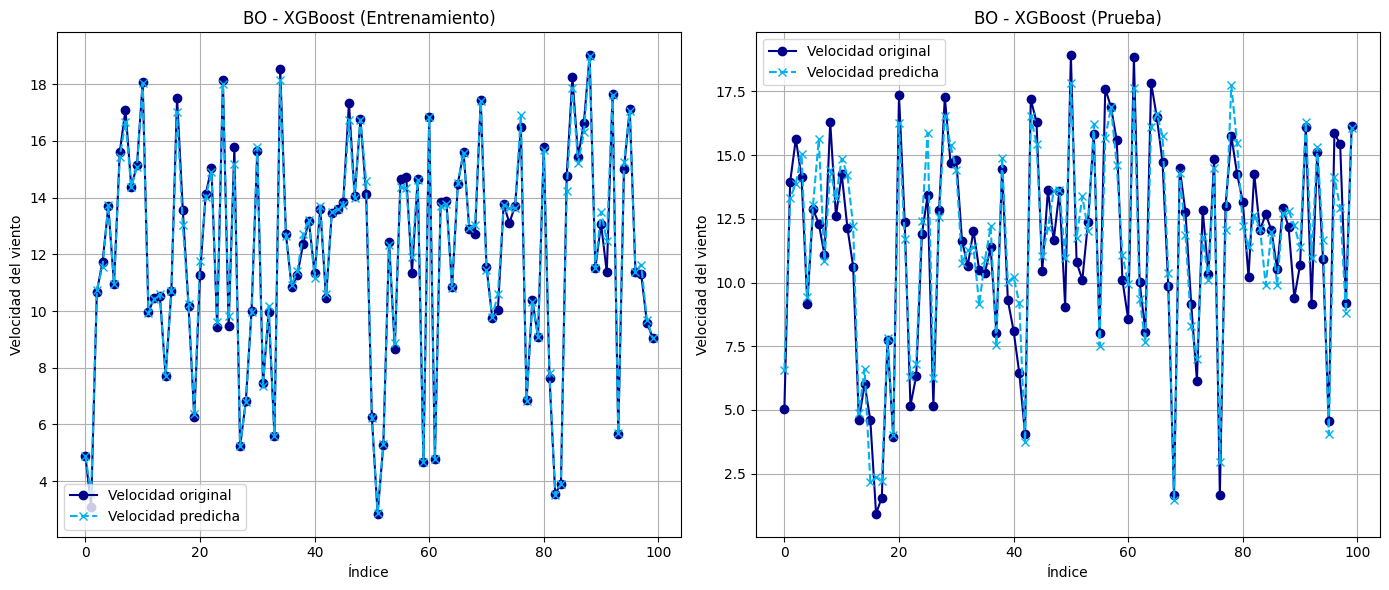

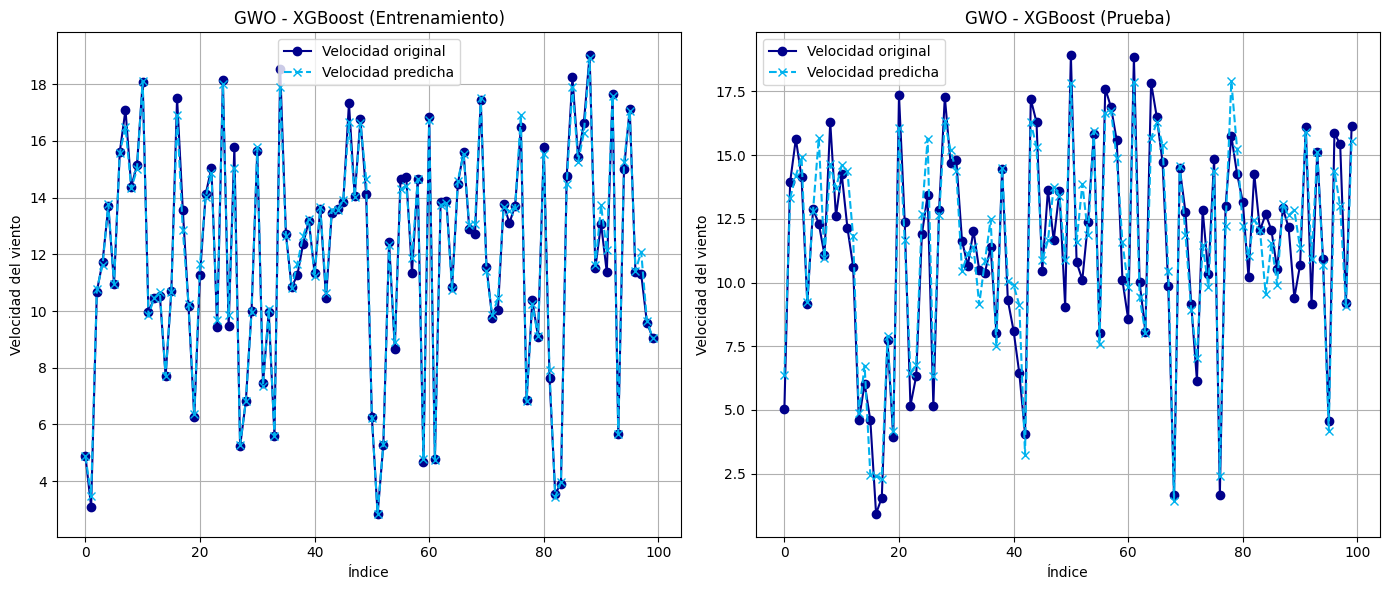

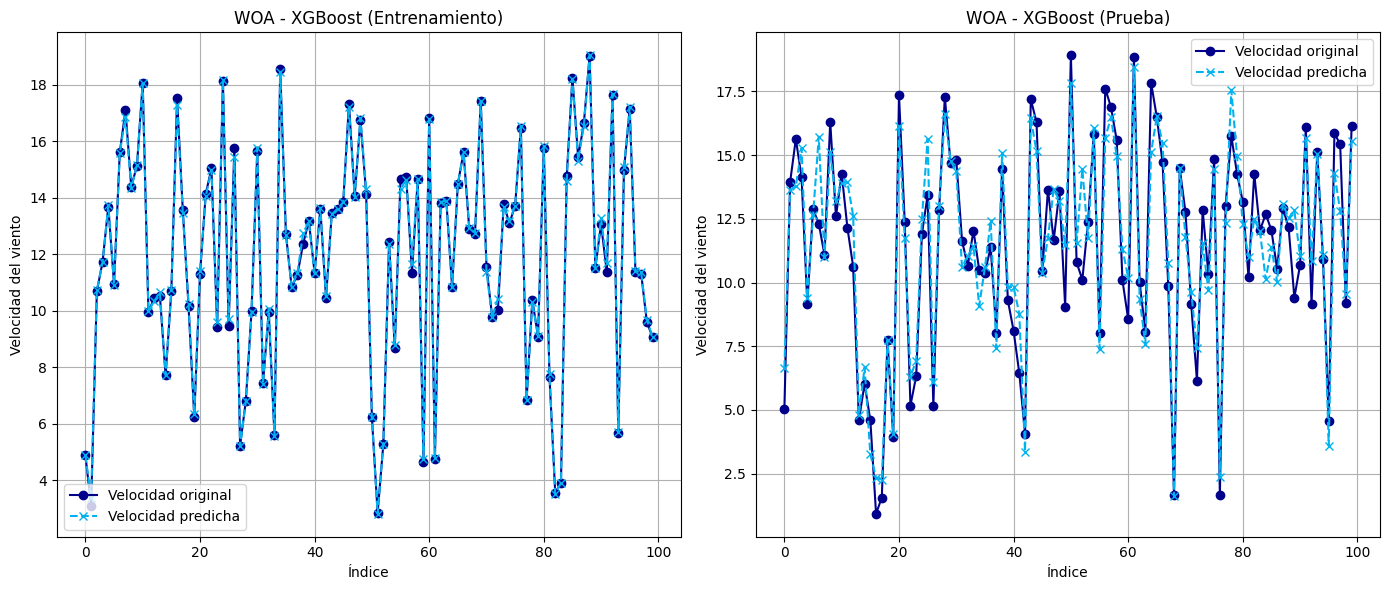

In [53]:
for resultado in resultados_graficos5_original_cargado:
    # Gráfica de predicciones
    grafica(
        resultado['nombre_modelo'],
        resultado['y_train'], resultado['y_train_pred'],
        resultado['y_test'], resultado['y_test_pred']
    )

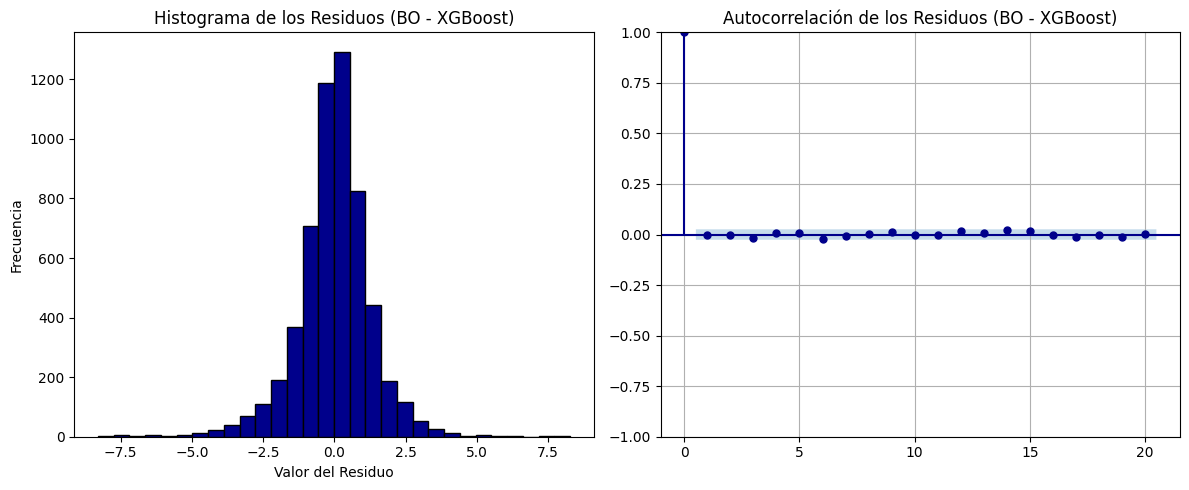

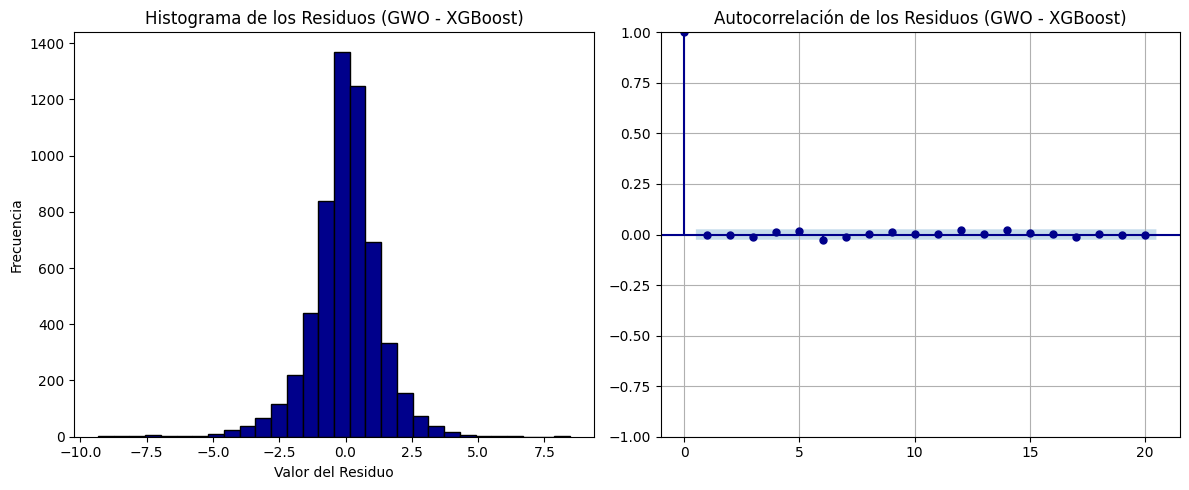

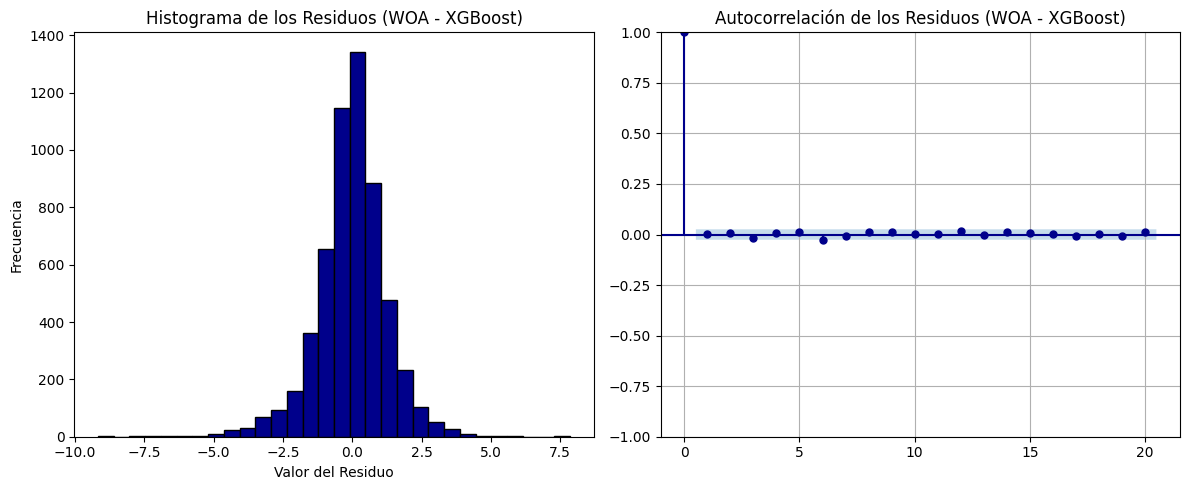

In [54]:
for resultado in resultados_graficos5_original_cargado:
    grafica_residuos(
        resultado['nombre_modelo'],
        resultado['residuos']
    )

## **Interpretación de resultados**

En conclusión, al evaluar los resultados para la predicción de la velocidad del viento a diferentes alturas, se observa que **WOA-XGBoost** generalmente ofrece el mejor ajuste, alcanzando valores de **R²** elevados, especialmente en las alturas de 100 m, con un **R² de 0.8974** en el sensor 1 (NW). Aunque este algoritmo suele tener un tiempo de ejecución superior, no siempre es el caso, ya que en algunas alturas otros métodos pueden ser más eficientes en cuanto a tiempo sin sacrificar demasiado el rendimiento. En términos generales, los modelos presentan un buen ajuste tanto para los conjuntos de entrenamiento como de prueba, con algunos modelos como WOA-XGBoost destacando por un mejor desempeño en los primeros. No obstante, los residuos de los modelos, aunque visualmente cercanos a una distribución normal, muestran indicios de distorsión debido a la presencia de **valores atípicos**, lo que podría afectar la validez de ciertas suposiciones sobre la normalidad. Sin embargo, a pesar de estos pequeños inconvenientes, los modelos evaluados ofrecen predicciones razonablemente precisas y efectivas para la estimación de la velocidad del viento en diferentes alturas.